<a href="https://colab.research.google.com/github/tofighi/MachineLearning/blob/master/daily_vaccination_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# 1. Download the dataset from the same source
url = "https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))



In [ ]:
data.shape

(196246, 16)

In [ ]:
# 2. Data Preprocessing
# Fill missing values with forward fill (for time series continuity) and drop rows where critical columns are still missing
df = data[['date', 'location', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations']].ffill().dropna()

# Convert date to datetime and extract the day of the year as a numerical feature
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].dt.dayofyear

# Features and target
features = df[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
target = df['daily_vaccinations']




In [5]:
df.head()

date     location  total_vaccinations  people_vaccinated  \
78 2021-05-11  Afghanistan            504502.0           448878.0   
79 2021-05-12  Afghanistan            504502.0           448878.0   
80 2021-05-13  Afghanistan            504502.0           448878.0   
81 2021-05-14  Afghanistan            504502.0           448878.0   
82 2021-05-15  Afghanistan            504502.0           448878.0   

    people_fully_vaccinated  daily_vaccinations  day_of_year  
78                  55624.0             13921.0          131  
79                  55624.0             12621.0          132  
80                  55624.0             11321.0          133  
81                  55624.0             10022.0          134  
82                  55624.0              8722.0          135

In [19]:
# prompt: create a data frame that just contain locations which are countries (not a continent or area)

df_countries = df[~df['location'].isin(['World', 'Asia', 'Europe', 'European Union', 'North America', 'South America', 'Africa', 'Oceania'])]


In [32]:
# prompt: create dataset that just contains data for continents

df_continents = df[df['location'].isin(['World', 'Asia', 'Europe', 'European Union', 'North America', 'South America', 'Africa', 'Oceania'])]


In [33]:
df_continents

date location  total_vaccinations  people_vaccinated  \
1043   2021-01-09   Africa        0.000000e+00       0.000000e+00   
1044   2021-01-10   Africa        0.000000e+00       0.000000e+00   
1045   2021-01-11   Africa        0.000000e+00       0.000000e+00   
1046   2021-01-12   Africa        0.000000e+00       0.000000e+00   
1047   2021-01-13   Africa        2.000000e+03       2.000000e+03   
...           ...      ...                 ...                ...   
193893 2024-08-10    World        1.357876e+10       5.631264e+09   
193894 2024-08-11    World        1.357877e+10       5.631264e+09   
193895 2024-08-12    World        1.357877e+10       5.631264e+09   
193896 2024-08-13    World        1.357877e+10       5.631264e+09   
193897 2024-08-14    World        1.357877e+10       5.631264e+09   

        people_fully_vaccinated  daily_vaccinations  day_of_year  
1043               1.837039e+07                 0.0            9  
1044               1.837039e+07               500.0           10  
1045               1.837039e+07               500.0           11  
1046               1.837039e+07               500.0           12  
1047               1.837039e+07               500.0           13  
...                         ...                 ...          ...  
193893             5.177943e+09              1340.0          223  
193894             5.177943e+09              1340.0          224  
193895             5.177943e+09              1340.0          225  
193896             5.177943e+09              1340.0          226  
193897             5.177943e+09              1340.0          227  

[10217 rows x 7 columns]

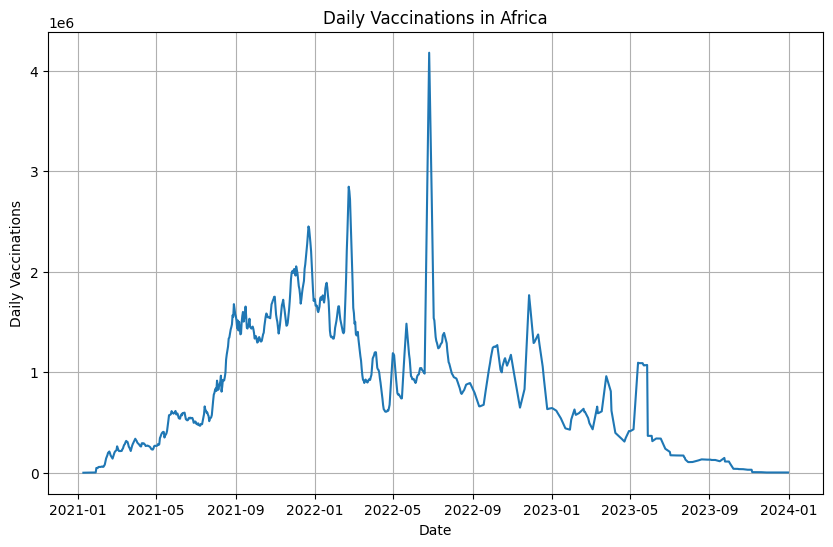

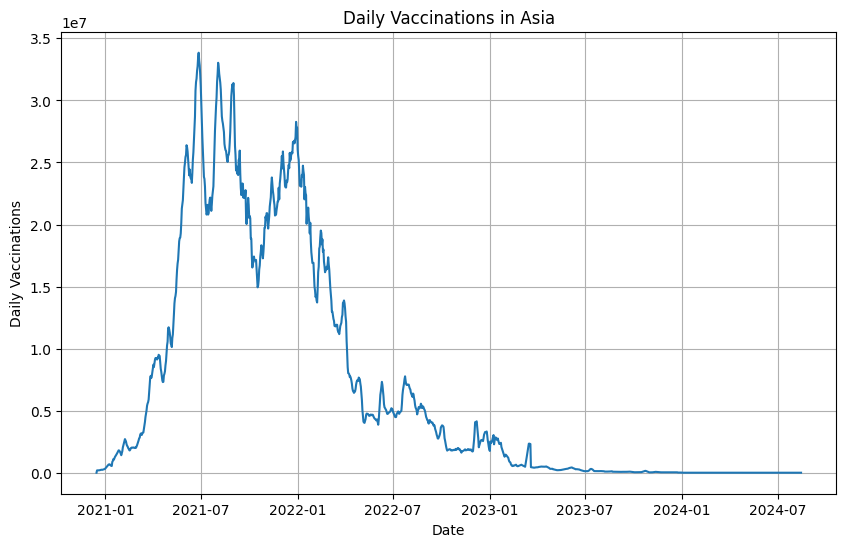

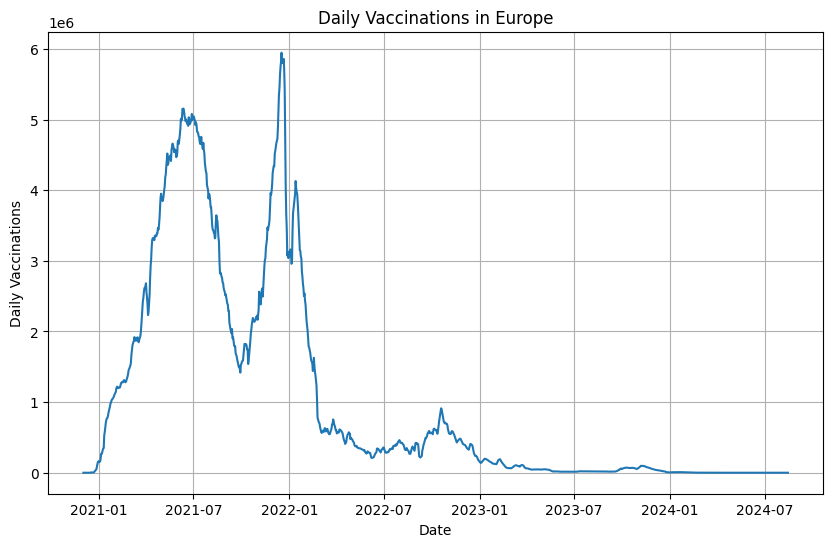

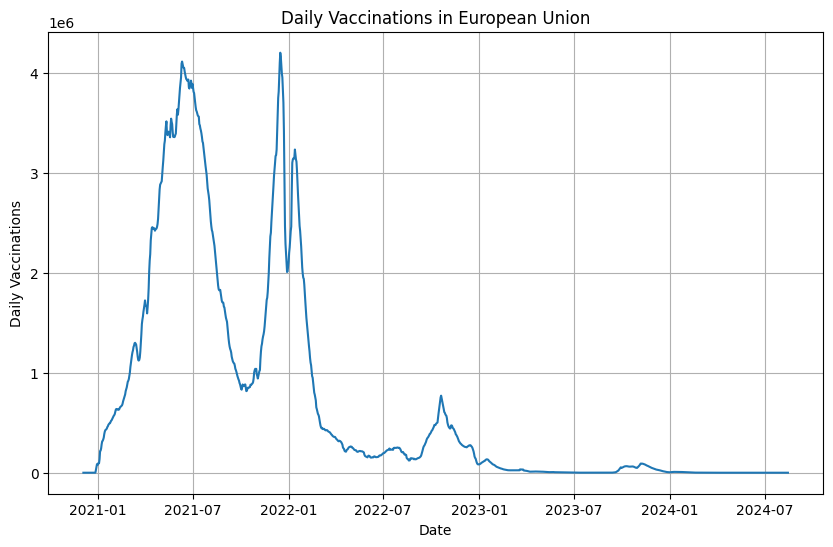

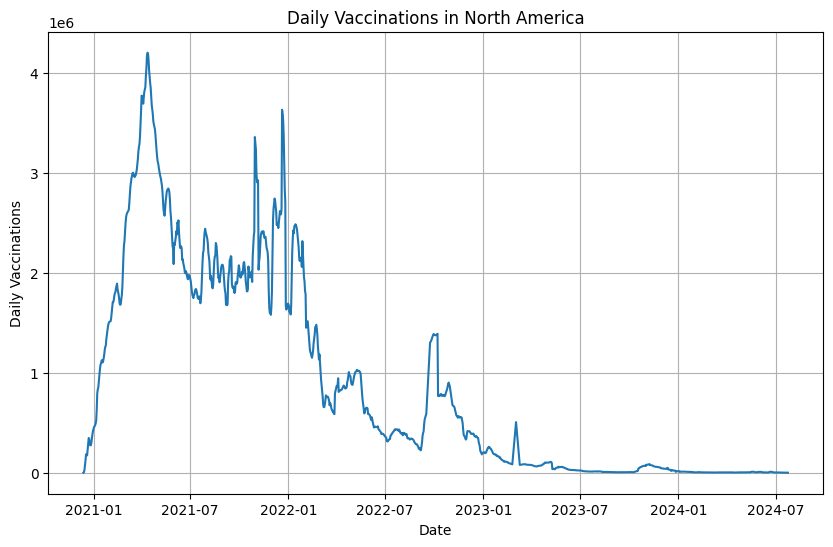

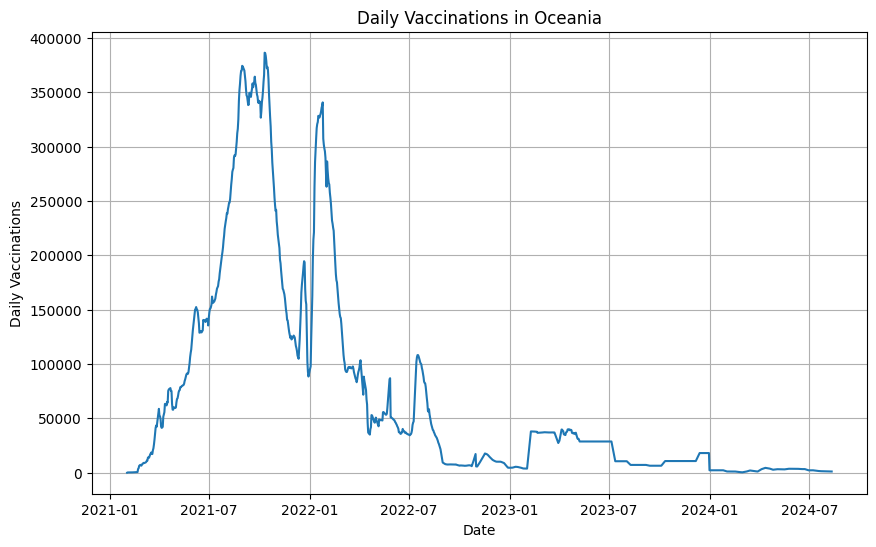

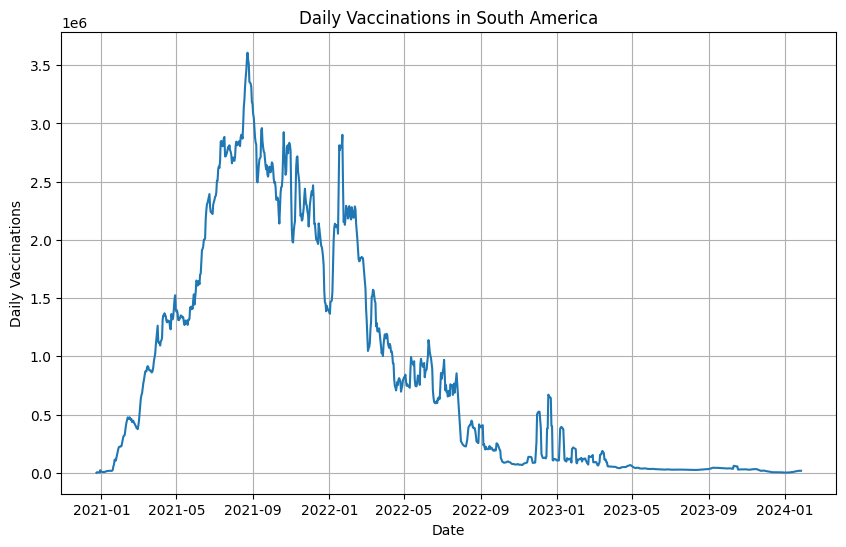

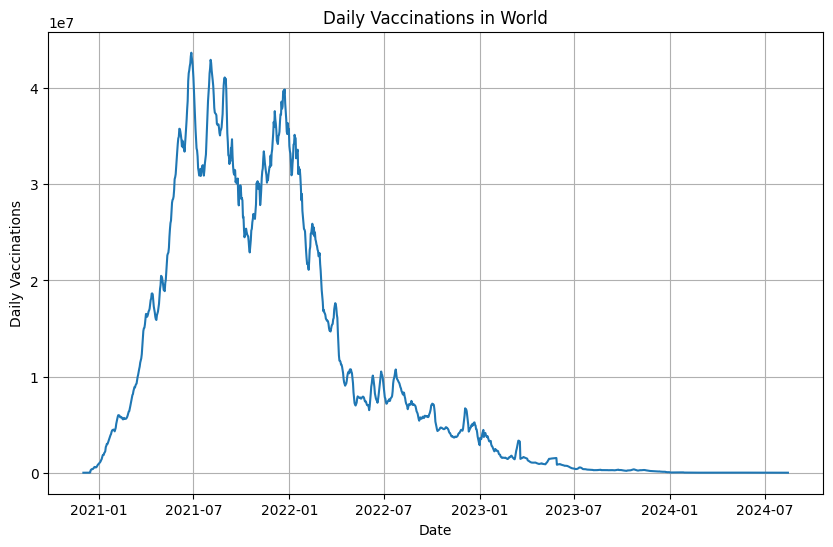

In [43]:
# prompt: show graph of each continent for daily vaccinations

import matplotlib.pyplot as plt

for continent in df_continents['location'].unique():
  df_continent = df_continents[df_continents['location'] == continent]
  plt.figure(figsize=(10, 6))
  plt.plot(df_continent['date'], df_continent['daily_vaccinations'])
  plt.title(f'Daily Vaccinations in {continent}')
  plt.xlabel('Date')
  plt.ylabel('Daily Vaccinations')
  plt.grid(True)
  plt.show()


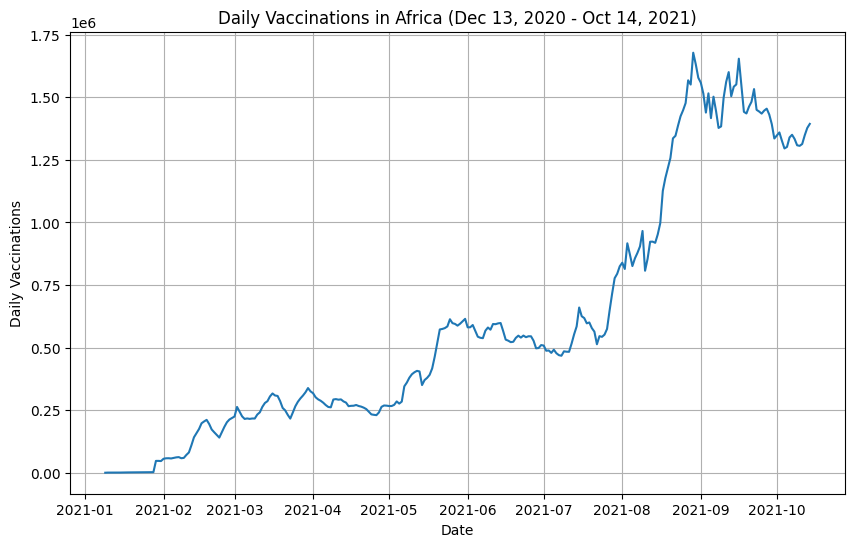

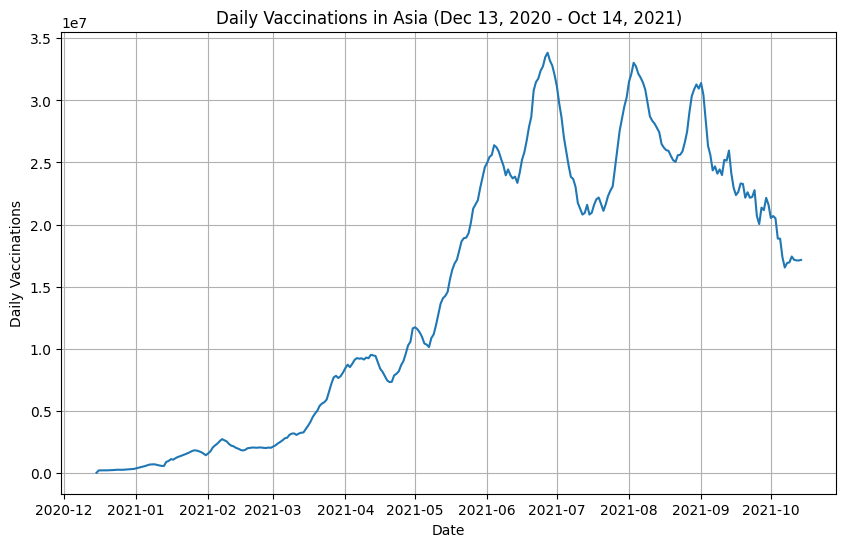

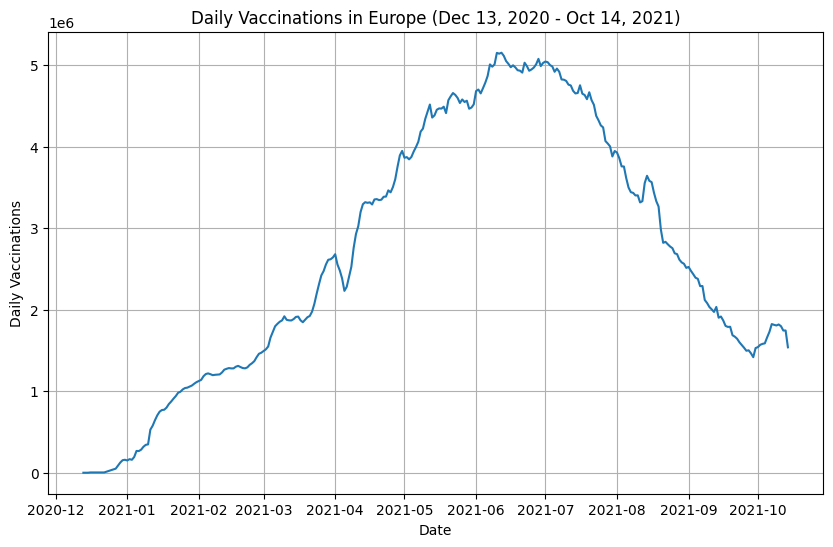

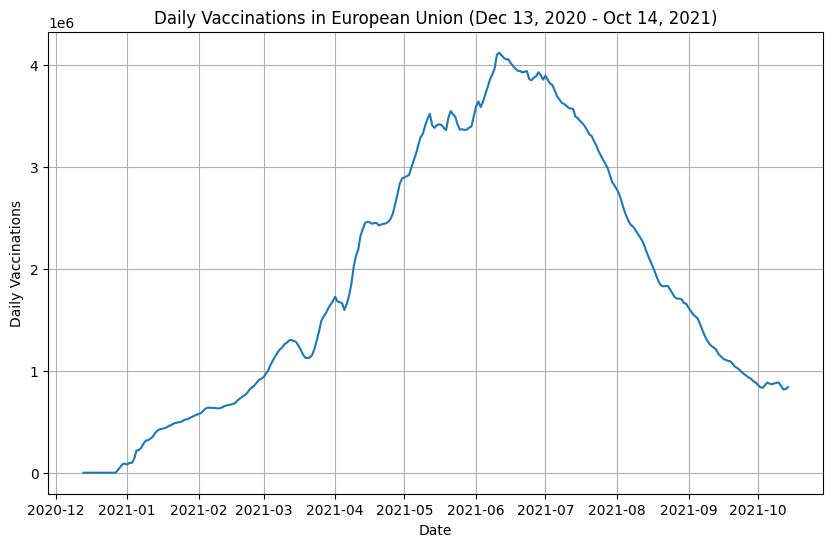

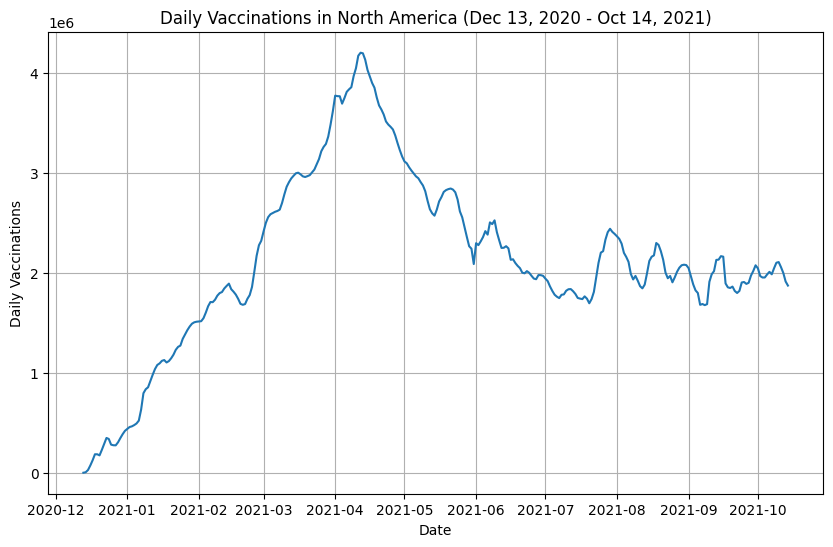

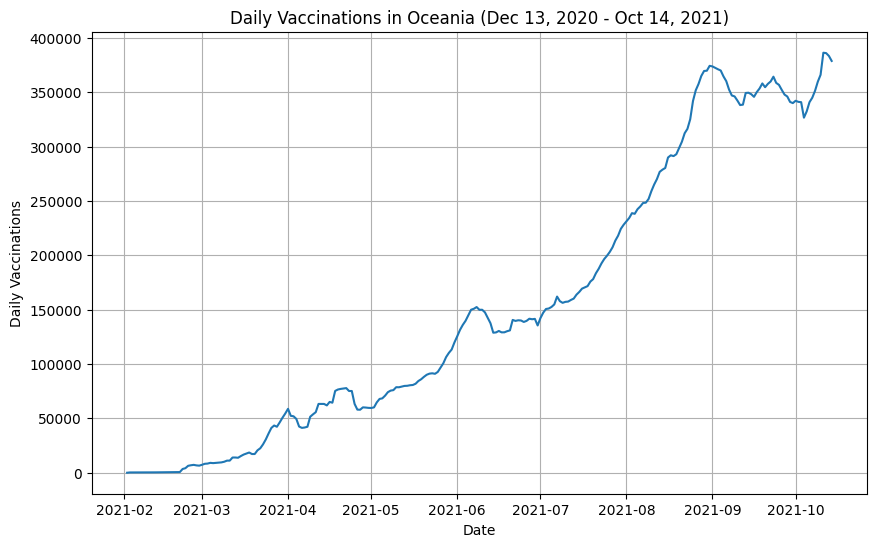

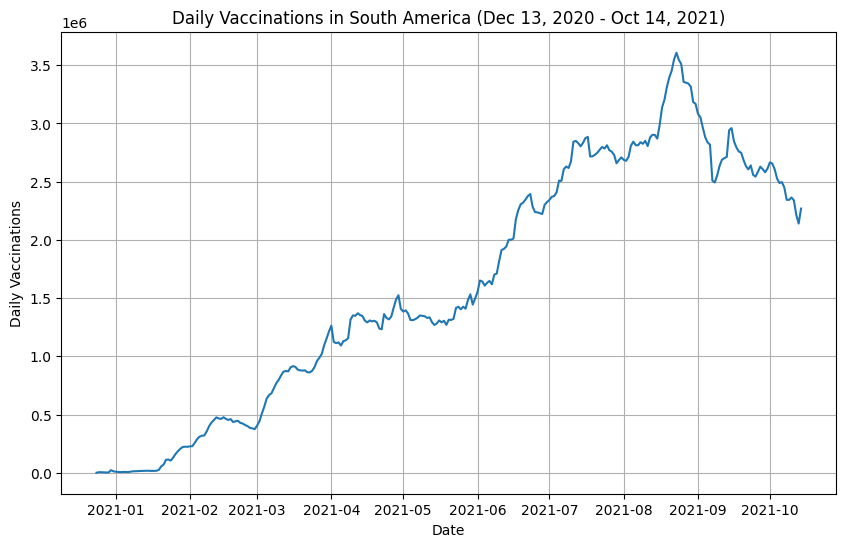

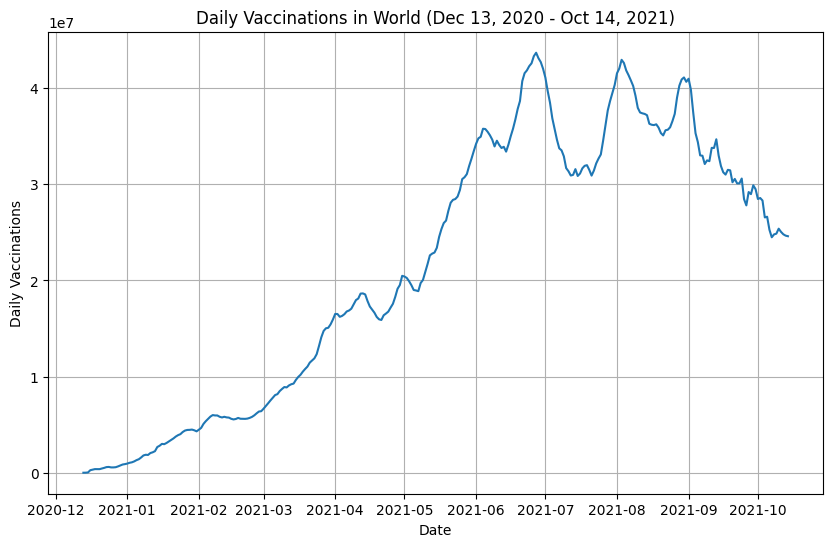

In [48]:
# prompt: create graphs again from the 13th of December 2020 to the 14th of October 2021.

import matplotlib.pyplot as plt
for continent in df_continents['location'].unique():
  df_continent = df_continents[df_continents['location'] == continent]
  df_continent = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-10-14')]
  plt.figure(figsize=(10, 6))
  plt.plot(df_continent['date'], df_continent['daily_vaccinations'])
  plt.title(f'Daily Vaccinations in {continent} (Dec 13, 2020 - Oct 14, 2021)')
  plt.xlabel('Date')
  plt.ylabel('Daily Vaccinations')
  plt.grid(True)
  plt.show()


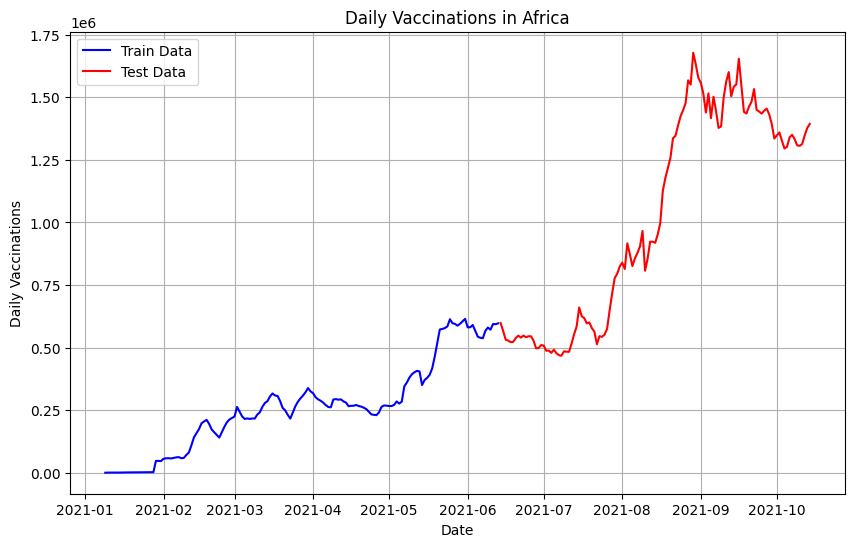

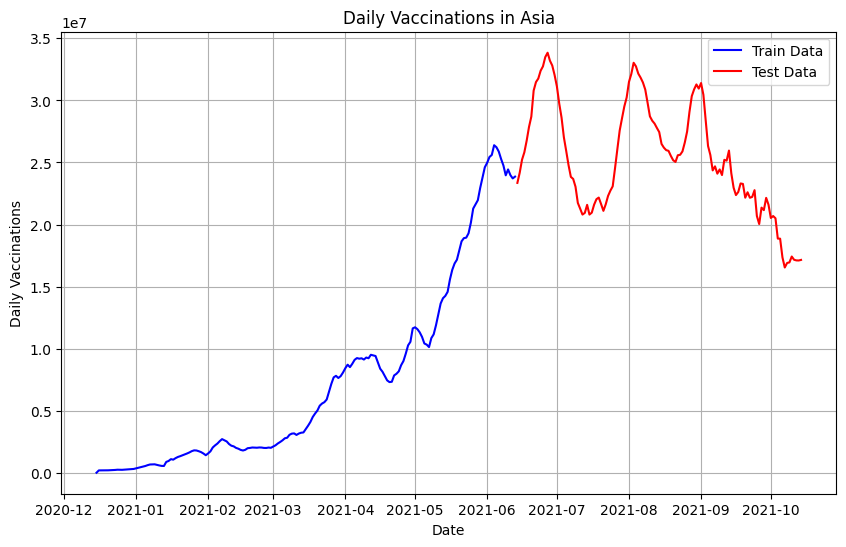

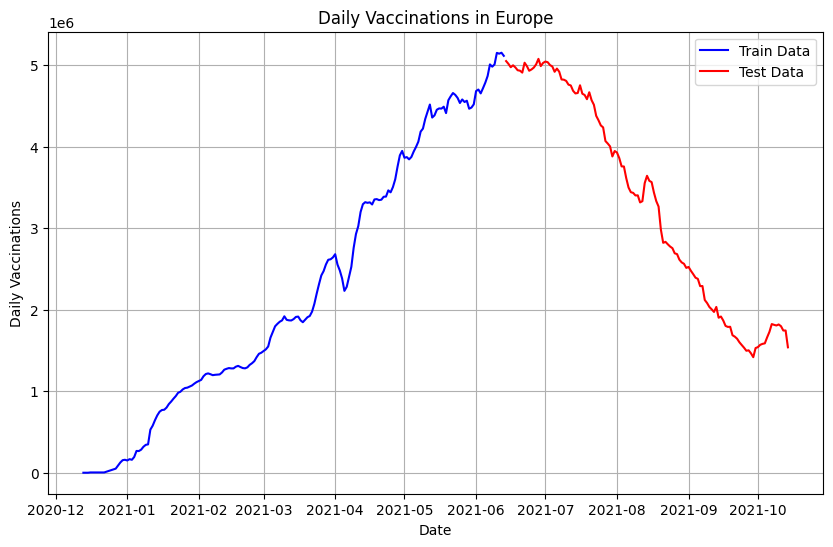

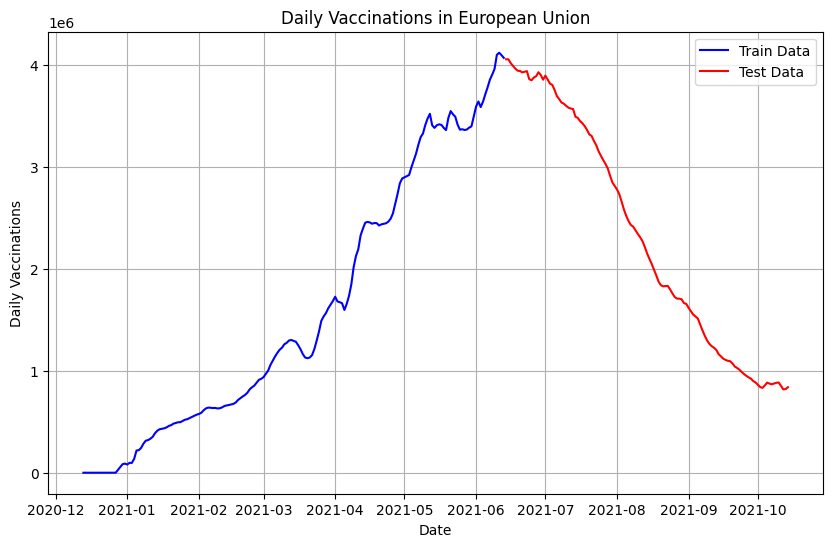

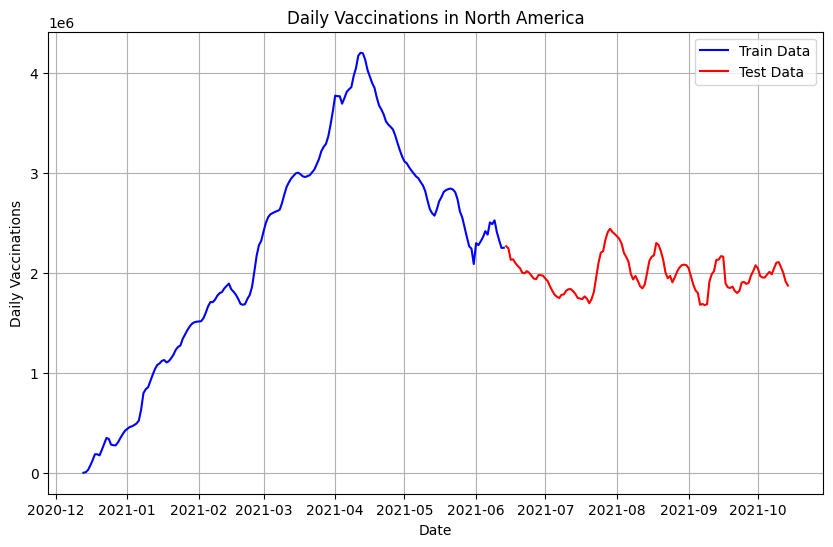

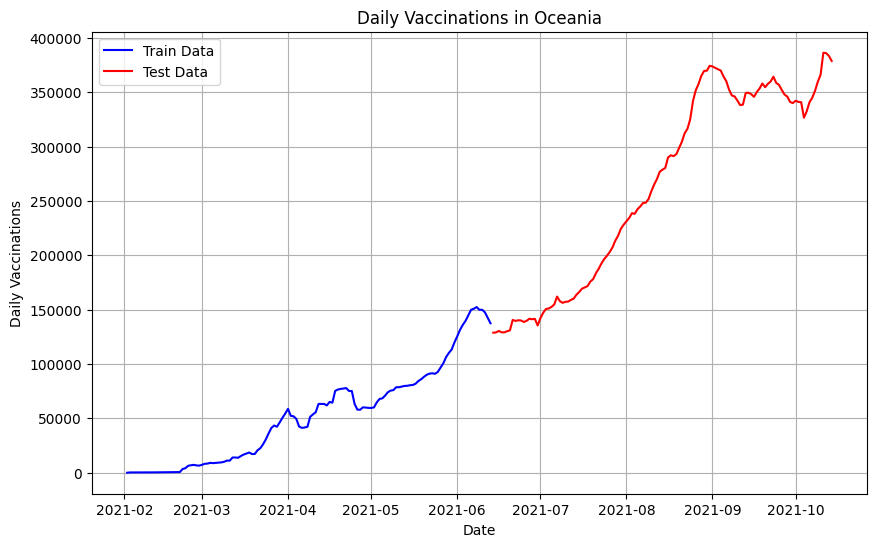

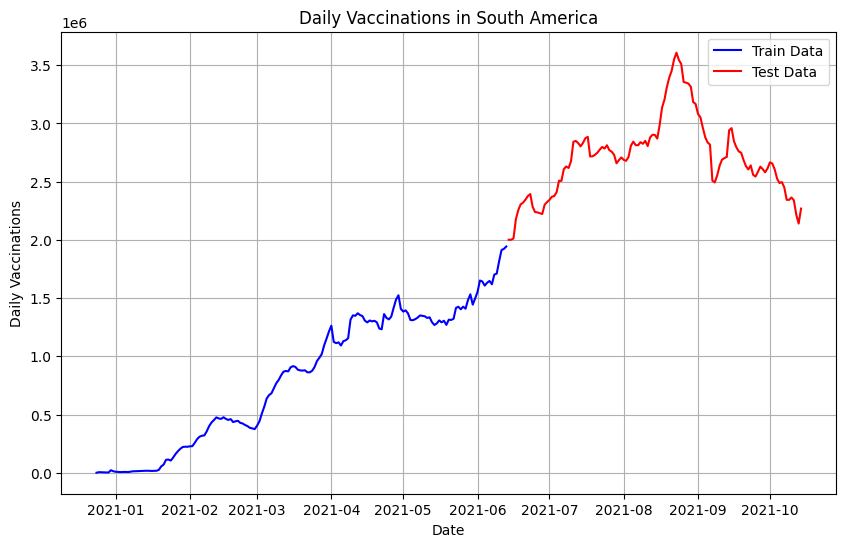

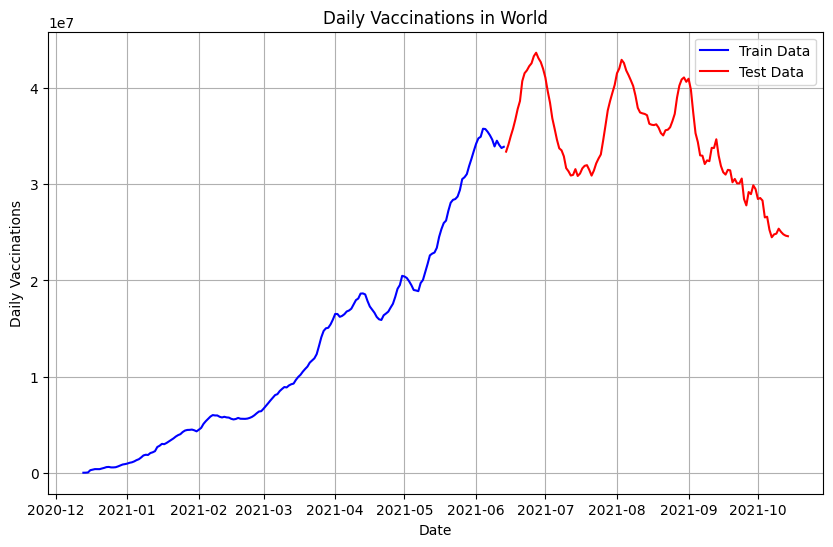

In [47]:
# prompt: create graphs again and use different blue for daily data from the 13th of December 2020 to the 13th of June 2021,  and red from the 14th of June 2021 to the 14th of October 2021, label the blue part of graph as train data, and red part of graph as test data

import matplotlib.pyplot as plt

for continent in df_continents['location'].unique():
    df_continent = df_continents[df_continents['location'] == continent]
    plt.figure(figsize=(10, 6))

    # Filter data for the specified date ranges
    train_data = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-06-13')]
    test_data = df_continent[(df_continent['date'] >= '2021-06-14') & (df_continent['date'] <= '2021-10-14')]

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')


    plt.title(f'Daily Vaccinations in {continent}')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()  # Show the legend for train and test data
    plt.show()


In [49]:
# prompt: create train and test dataframe for each continent based on 13th of December 2020 to the 13th of June 2021 as train, while the testing dataset is comprised of COVID-19 daily data from the 14th of June 2021 to the 14th of October 2021.

train_dfs = {}
test_dfs = {}

for continent in df_continents['location'].unique():
    df_continent = df_continents[df_continents['location'] == continent]

    train_data = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-06-13')]
    test_data = df_continent[(df_continent['date'] >= '2021-06-14') & (df_continent['date'] <= '2021-10-14')]

    train_dfs[continent] = train_data
    test_dfs[continent] = test_data


In [54]:
# prompt: show shape of each of these train and test data for each continent separately (first world, then asia, ...) and head of each

for continent in df_continents['location'].unique():
  print(f"Continent: {continent}")
  print("Train Data Shape:", train_dfs[continent].shape)
  print("Test Data Shape:", test_dfs[continent].shape)
  print("\n")


Continent: Africa
Train Data Shape: (156, 7)
Test Data Shape: (123, 7)


Continent: Asia
Train Data Shape: (181, 7)
Test Data Shape: (123, 7)


Continent: Europe
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: European Union
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: North America
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: Oceania
Train Data Shape: (132, 7)
Test Data Shape: (123, 7)


Continent: South America
Train Data Shape: (172, 7)
Test Data Shape: (123, 7)


Continent: World
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)




In [ ]:

# Based on the time series nature of the data and the goal of predicting daily vaccinations,
# the following models are suggested:

# 1. ARIMA (Autoregressive Integrated Moving Average):
#    - ARIMA models are well-suited for time series data with trends and seasonality.
#    - They can capture the dependencies between past and future values effectively.

# 2. Prophet (by Facebook):
#    - Prophet is a forecasting model specifically designed for time series data with seasonality and trend changes.
#    - It's robust to missing data and outliers.

# 3. LSTM (Long Short-Term Memory) Recurrent Neural Network:
#    - LSTMs are powerful deep learning models that can capture long-term dependencies in time series data.
#    - They are particularly effective when dealing with complex patterns and non-linear relationships.

# 4. Exponential Smoothing:
#    - Exponential smoothing methods assign weights to past observations, with more recent observations having higher weights.
#    - They are relatively simple to implement and can provide accurate forecasts for time series with trends and seasonality.

# 5. Gradient Boosting Regressors (e.g., XGBoost, LightGBM):
#    - These models can capture complex non-linear relationships in the data.
#    - They can also handle features like day_of_year, total vaccinations, etc., which might be relevant to predict daily vaccinations.


# Model Selection Considerations:

# - Data Size: For smaller datasets, simpler models like ARIMA or Exponential Smoothing might be sufficient.
#   For larger datasets with complex patterns, LSTMs or Gradient Boosting models could be more effective.
# - Computational Resources: LSTMs can be computationally intensive, especially with large datasets.
# - Interpretability: ARIMA and Exponential Smoothing models are relatively easy to interpret, while LSTMs and Gradient Boosting models might be harder to understand.
# - Accuracy: The best model will depend on the specific dataset and the desired level of accuracy.


# To choose the best model for this specific task, you could perform a comparative analysis
# by training and evaluating each of these models on your training and testing datasets.
# Evaluate based on metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE),
# and compare their performance.

# Example (using ARIMA and Prophet):
# For each continent:

# 1. Prepare the data for each model (may require some preprocessing specific to each model).
# 2. Train the ARIMA and Prophet models using your train data.
# 3. Make predictions on your test data.
# 4. Calculate MAE and RMSE for both models on your test data.
# 5. Analyze the results and identify the model that provides the best performance.



In [94]:

# Feature Selection for Different Models

# Create a dictionary to store feature sets for each model and continent
feature_sets = {}

for continent in df_continents['location'].unique():
    feature_sets[continent] = {}

    # ARIMA
    feature_sets[continent]['ARIMA'] = ['daily_vaccinations']  # ARIMA primarily uses past values of the target

    # Prophet
    feature_sets[continent]['Prophet'] = ['date', 'daily_vaccinations']  # Prophet uses date and target for forecasting

    # LSTM
    feature_sets[continent]['LSTM'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Exponential Smoothing
    feature_sets[continent]['Exponential Smoothing'] = ['daily_vaccinations']

    # XGBoost, LightGBM
    feature_sets[continent]['XGBoost'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']
    feature_sets[continent]['LightGBM'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Elastic Net (ENET)
    feature_sets[continent]['ENET'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # CUBIST
    feature_sets[continent]['CUBIST'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Gausian Process (GAUSS)
    feature_sets[continent]['GAUSS'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Spikes and Slab (SPIKES)
    feature_sets[continent]['SPIKES'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']


# Create DataFrames for each model and continent based on selected features
model_dfs = {}

for continent in df_continents['location'].unique():
    model_dfs[continent] = {}
    for model_name, features in feature_sets[continent].items():
        model_dfs[continent][model_name] = train_dfs[continent][features]

# Now, model_dfs[continent][model_name] contains the DataFrame with selected features for each model and continent.
# You can use these DataFrames to train and evaluate your chosen models.


In [128]:
# prompt: implement Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE) , and Mean Absolute Scaled Error (MASE)  functions and if there are missing values handle them,

import numpy as np

def relative_absolute_error(y_true, y_pred):
  """
  Calculate the Relative Absolute Error (RAE).

  Args:
    y_true: True values.
    y_pred: Predicted values.

  Returns:
    The RAE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  numerator = np.sum(np.abs(y_true - y_pred))
  denominator = np.sum(np.abs(y_true - np.mean(y_true)))

  if denominator == 0:
      return 0  # Avoid division by zero

  return numerator / denominator

def mean_squared_log_error(y_true, y_pred):
  """
  Calculate the Mean Squared Log Error (MSLE).

  Args:
    y_true: True values.
    y_pred: Predicted values.

  Returns:
    The MSLE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Handle potential issues with negative or zero values
  y_true = np.clip(y_true, 1e-10, float('inf'))
  y_pred = np.clip(y_pred, 1e-10, float('inf'))

  return np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred)))

def mean_absolute_scaled_error(y_true, y_pred, seasonality=1):
  """
  Calculate the Mean Absolute Scaled Error (MASE).

  Args:
    y_true: True values.
    y_pred: Predicted values.
    seasonality: The seasonality period (e.g., 7 for weekly data, 365 for yearly data).

  Returns:
    The MASE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  n = len(y_true)
  errors = np.abs(y_true - y_pred)

  # Calculate the mean absolute error of the naive forecast
  naive_errors = np.abs(y_true[seasonality:] - y_true[:-seasonality])
  mae_naive = np.mean(naive_errors)

  # Handle potential issues with zero or near-zero values
  if mae_naive == 0:
      return 0

  return np.mean(errors) / mae_naive

def handle_missing_values(df, method='ffill'):
    """
    Handle missing values in a DataFrame.

    Args:
        df: DataFrame with missing values.
        method: Method for filling missing values.
                'ffill': Forward fill.
                'bfill': Backward fill.
                'mean': Fill with the mean of the column.
                'median': Fill with the median of the column.

    Returns:
        DataFrame with missing values handled.
    """
    if method == 'ffill':
        return df.fillna(method='ffill')
    elif method == 'bfill':
        return df.fillna(method='bfill')
    elif method == 'mean':
        return df.fillna(df.mean())
    elif method == 'median':
        return df.fillna(df.median())
    else:
        raise ValueError(f"Unsupported method: {method}")




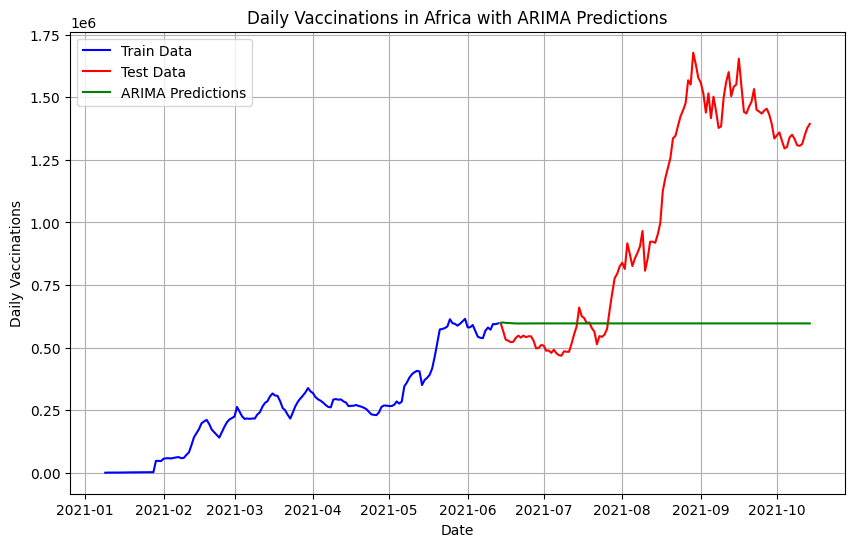

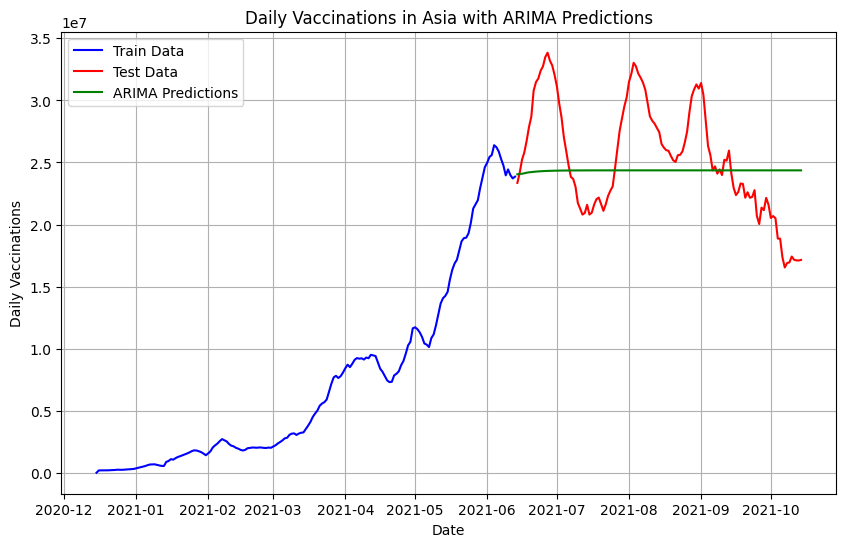

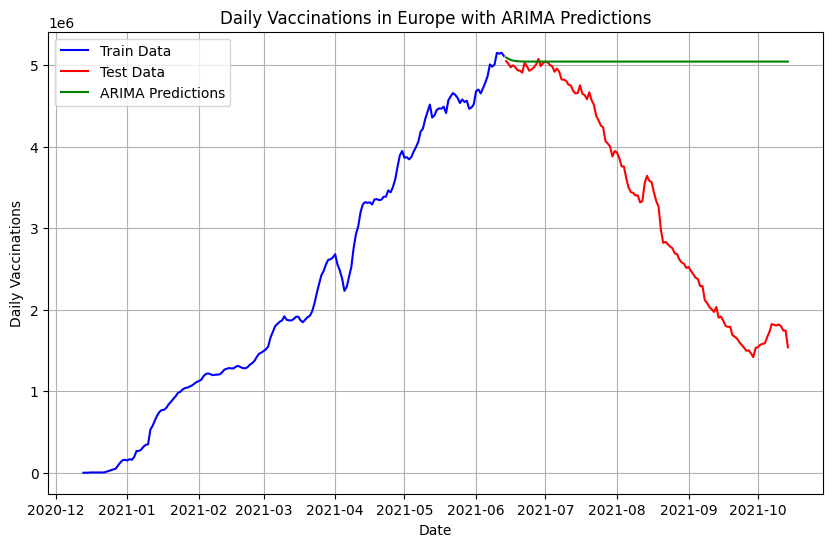

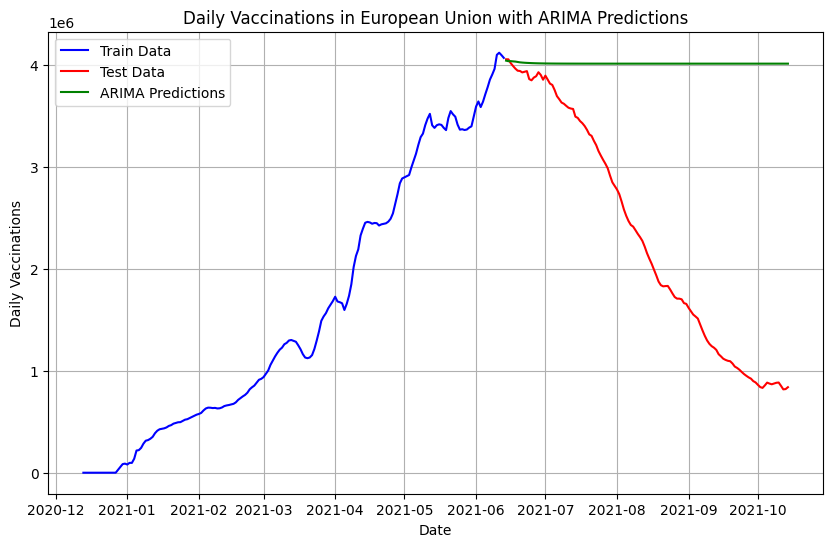

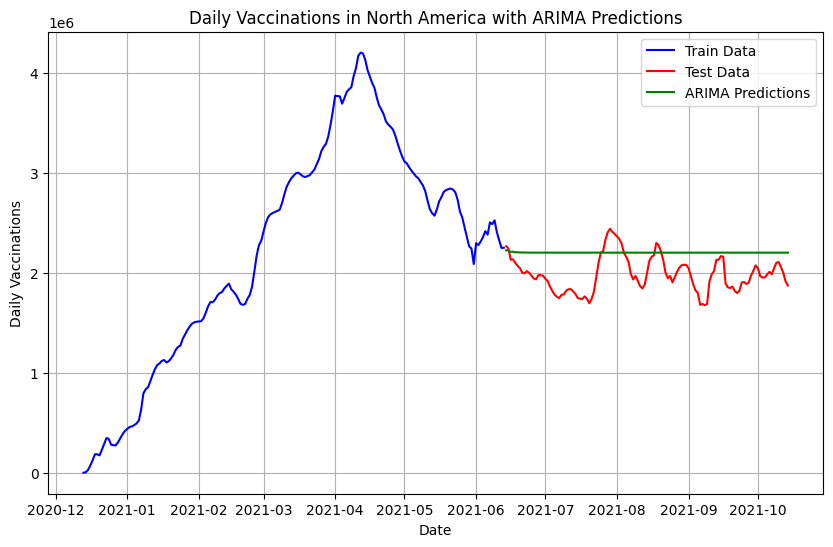

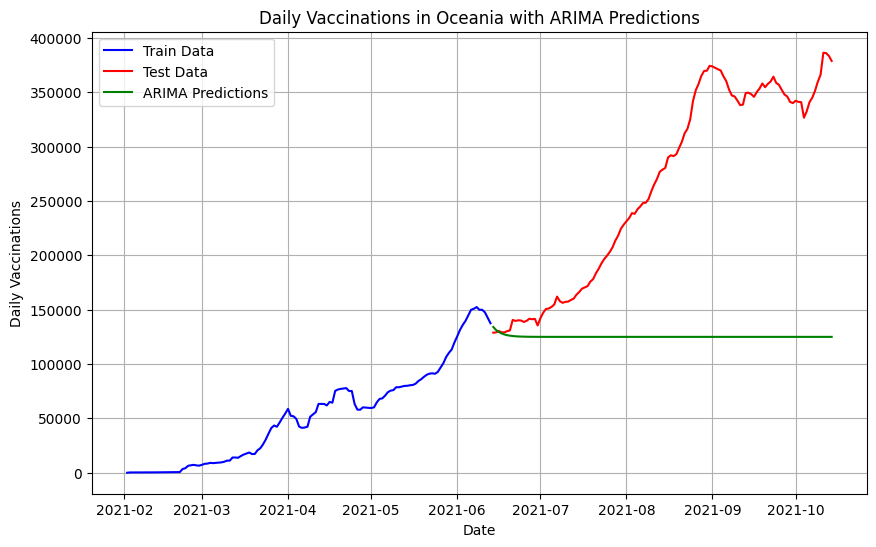

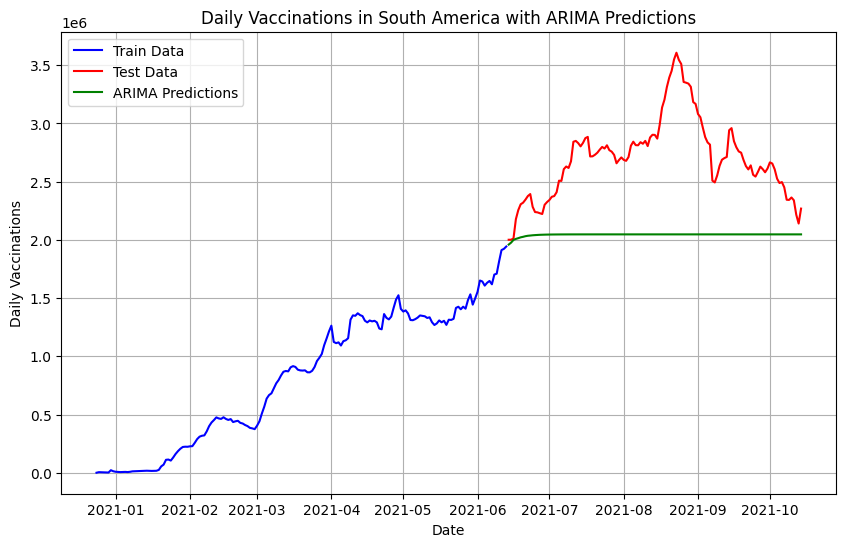

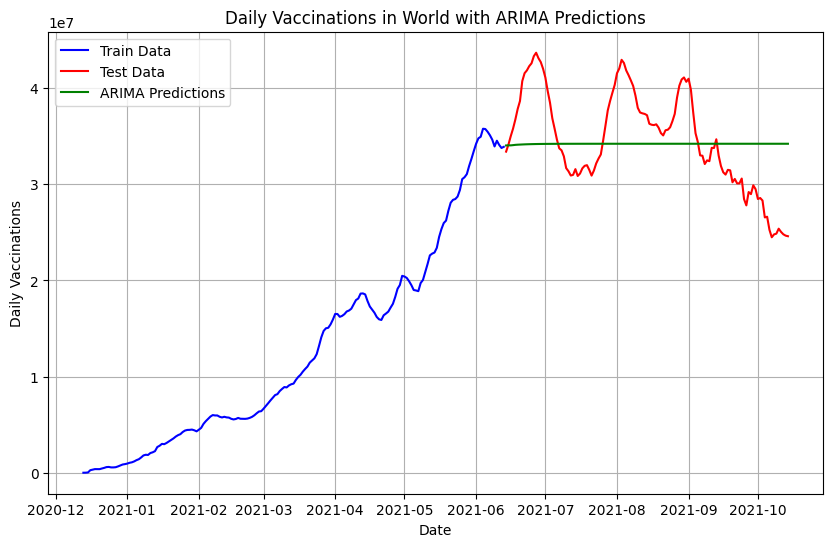


ARIMA RAE:
                             Value
ARIMA_Africa_RAE          1.188327
ARIMA_Asia_RAE            1.013650
ARIMA_Europe_RAE          1.475072
ARIMA_European Union_RAE  1.645809
ARIMA_North America_RAE   1.757336
ARIMA_Oceania_RAE         1.674832
ARIMA_South America_RAE   2.585018
ARIMA_World_RAE           1.004312

ARIMA MSLE:
                              Value
ARIMA_Africa_MSLE          0.396145
ARIMA_Asia_MSLE            0.033828
ARIMA_Europe_MSLE          0.443042
ARIMA_European Union_MSLE  0.775860
ARIMA_North America_MSLE   0.018952
ARIMA_Oceania_MSLE         0.604982
ARIMA_South America_MSLE   0.088706
ARIMA_World_MSLE           0.022886

ARIMA MASE:
                              Value
ARIMA_Africa_MASE          4.107057
ARIMA_Asia_MASE            1.126965
ARIMA_Europe_MASE          6.887811
ARIMA_European Union_MASE  8.812520
ARIMA_North America_MASE   1.239392
ARIMA_Oceania_MASE         6.732624
ARIMA_South America_MASE   3.121096
ARIMA_World_MASE           1.254222

In [129]:
# prompt: train and  test for ARIMA model for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output


arima_results = {}
arima_predictions_dfs = {}

for continent in df_continents['location'].unique():
    train_data = train_dfs[continent]
    test_data = test_dfs[continent]

    # Prepare the data for ARIMA
    train_data_arima = train_data[['date', 'daily_vaccinations']].set_index('date')
    test_data_arima = test_data[['date', 'daily_vaccinations']].set_index('date')

    # Train the ARIMA model
    try:
        model = ARIMA(train_data_arima['daily_vaccinations'], order=(5, 1, 0))  # Example order, adjust as needed
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima) + len(test_data_arima) - 1)

        # Evaluate the model
        mae = mean_absolute_error(test_data_arima['daily_vaccinations'], predictions)
        mse = mean_squared_error(test_data_arima['daily_vaccinations'], predictions)
        rmse = np.sqrt(mse)
        rae = relative_absolute_error(test_data_arima['daily_vaccinations'], predictions)
        msle = mean_squared_log_error(test_data_arima['daily_vaccinations'], predictions)
        mase = mean_absolute_scaled_error(test_data_arima['daily_vaccinations'], predictions, seasonality=7)

        # Store the results
        arima_results[f'ARIMA_{continent}_RAE'] = rae
        arima_results[f'ARIMA_{continent}_MSLE'] = msle
        arima_results[f'ARIMA_{continent}_MASE'] = mase
        arima_predictions_dfs[f'ARIMA_{continent}_predictions'] = pd.DataFrame({'date': test_data_arima.index, 'daily_vaccinations': test_data_arima['daily_vaccinations'], 'predictions': predictions})

        # Plot the train, test, and predictions
        plt.figure(figsize=(10, 6))

        plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')
        plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')
        plt.plot(test_data['date'], predictions, color='green', label='ARIMA Predictions')

        plt.title(f'Daily Vaccinations in {continent} with ARIMA Predictions')
        plt.xlabel('Date')
        plt.ylabel('Daily Vaccinations')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error training ARIMA model for {continent}: {e}")


# Create DataFrames for RAE, MSLE, and MASE
arima_rae_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()
arima_msle_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()
arima_mase_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()

# Filter the DataFrames to include only the relevant metrics
arima_rae_df = arima_rae_df[arima_rae_df.index.str.contains('RAE')]
arima_msle_df = arima_msle_df[arima_msle_df.index.str.contains('MSLE')]
arima_mase_df = arima_mase_df[arima_mase_df.index.str.contains('MASE')]

# Show the results
print("\nARIMA RAE:")
print(arima_rae_df)
print("\nARIMA MSLE:")
print(arima_msle_df)
print("\nARIMA MASE:")
print(arima_mase_df)




INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/a2t7ryvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/f9xhvfpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79420', 'data', 'file=/tmp/tmpox5vopxy/a2t7ryvv.json', 'init=/tmp/tmpox5vopxy/f9xhvfpm.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_modeltx8b9anf/prophet_model-20240930083104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Africa


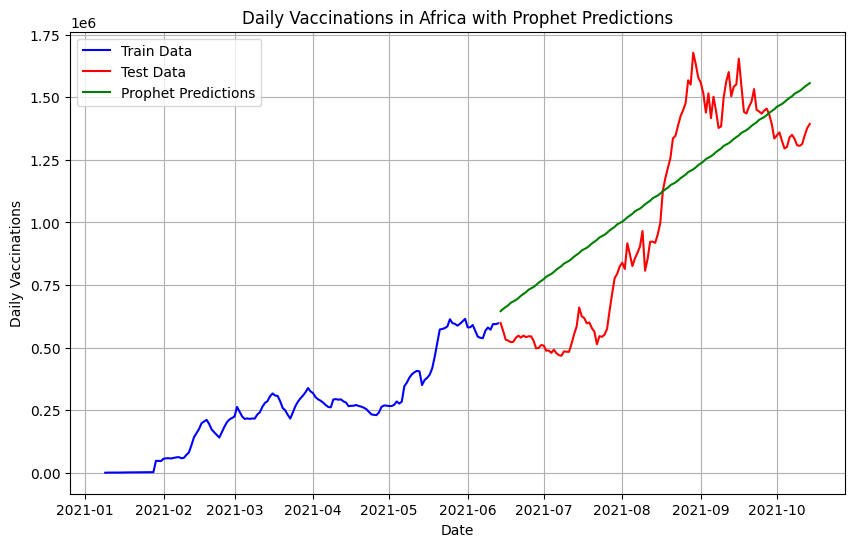

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/fd3q0fxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/ke78fzdh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66400', 'data', 'file=/tmp/tmpox5vopxy/fd3q0fxb.json', 'init=/tmp/tmpox5vopxy/ke78fzdh.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_modelevjqhqdf/prophet_model-20240930083104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Asia


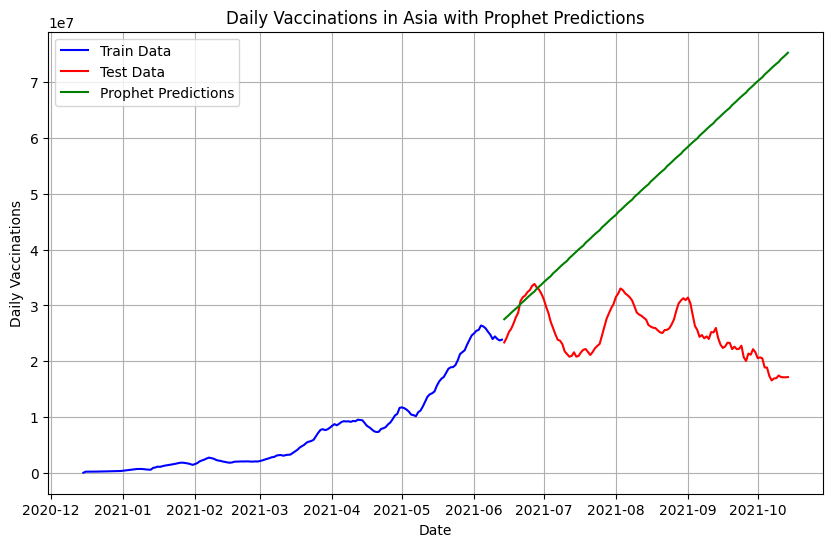

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/unkyrhm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/3sbzopfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76458', 'data', 'file=/tmp/tmpox5vopxy/unkyrhm_.json', 'init=/tmp/tmpox5vopxy/3sbzopfn.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_model3uo9dthw/prophet_model-20240930083105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Europe


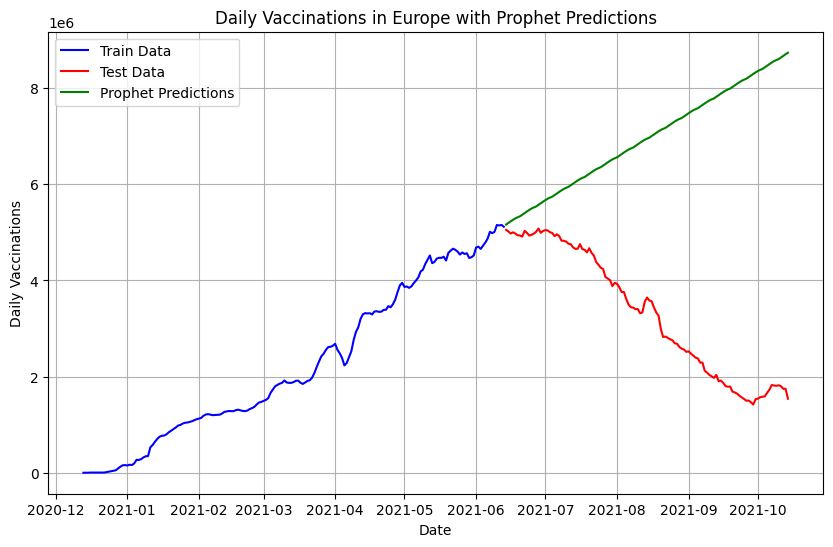

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/rwknd9cd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/4d5mankr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67679', 'data', 'file=/tmp/tmpox5vopxy/rwknd9cd.json', 'init=/tmp/tmpox5vopxy/4d5mankr.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_modelu7270ofi/prophet_model-20240930083106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for European Union


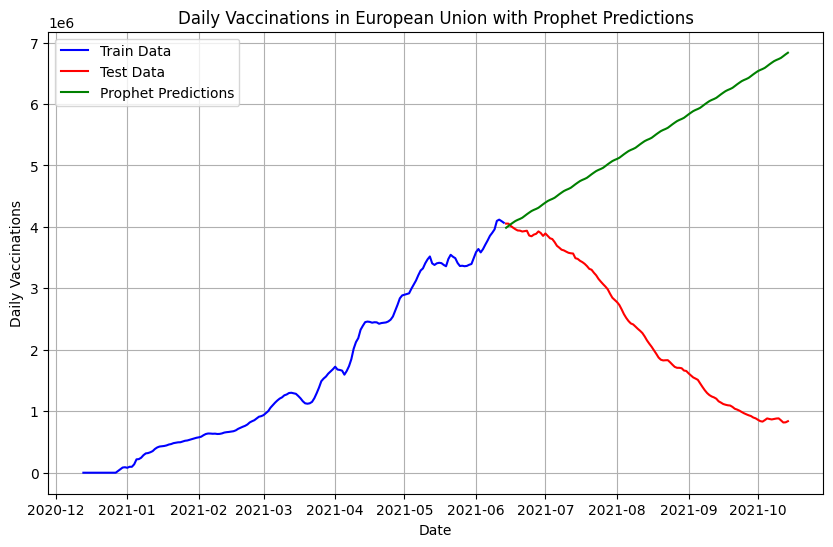

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/npr6595q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/38nntgf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1238', 'data', 'file=/tmp/tmpox5vopxy/npr6595q.json', 'init=/tmp/tmpox5vopxy/38nntgf4.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_model3nbxmugc/prophet_model-20240930083106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for North America


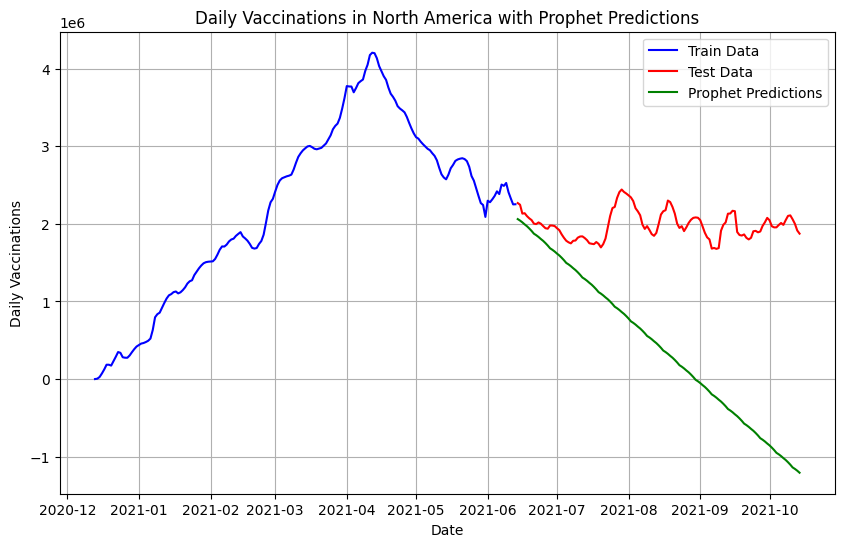

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/qqaockqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/3kw7owuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10595', 'data', 'file=/tmp/tmpox5vopxy/qqaockqw.json', 'init=/tmp/tmpox5vopxy/3kw7owuz.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_modelkst5dm7r/prophet_model-20240930083107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Oceania


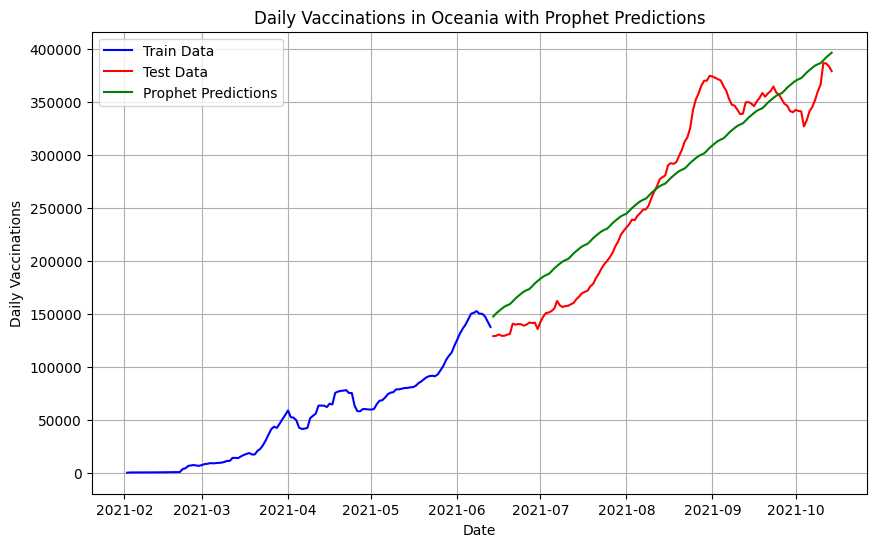

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/dm0py8ki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/rfq3wh5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23015', 'data', 'file=/tmp/tmpox5vopxy/dm0py8ki.json', 'init=/tmp/tmpox5vopxy/rfq3wh5x.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_model6uq7kolt/prophet_model-20240930083108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for South America


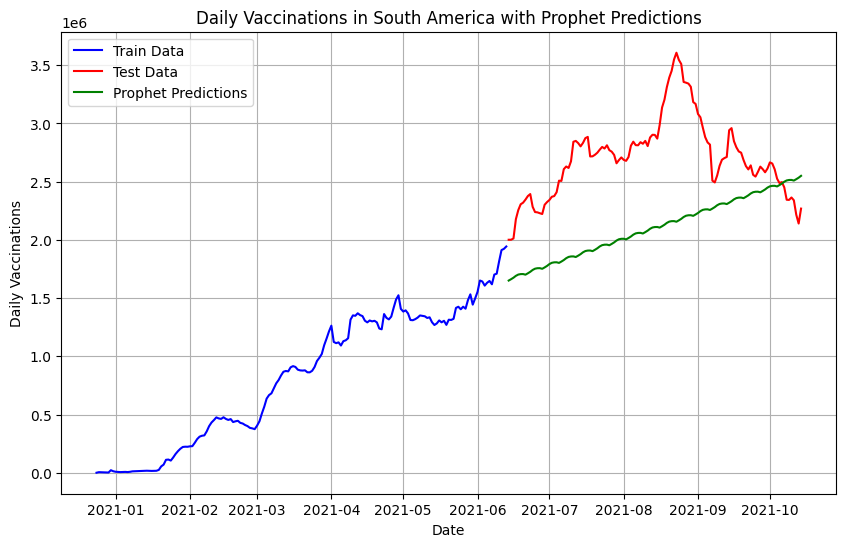

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/5js0yx48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpox5vopxy/o58ahixu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30717', 'data', 'file=/tmp/tmpox5vopxy/5js0yx48.json', 'init=/tmp/tmpox5vopxy/o58ahixu.json', 'output', 'file=/tmp/tmpox5vopxy/prophet_modellv5tltsb/prophet_model-20240930083108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for World


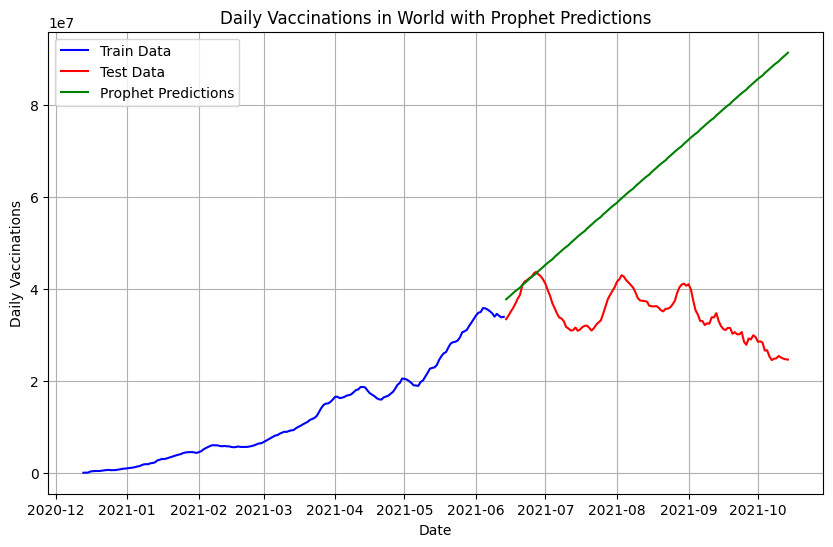

Prophet RAE DataFrame:
                                  RAE
Prophet_Africa_RAE           0.532640
Prophet_Asia_RAE             6.976264
Prophet_Europe_RAE           3.095716
Prophet_European Union_RAE   3.007323
Prophet_North America_RAE   11.273120
Prophet_Oceania_RAE          0.332396
Prophet_South America_RAE    2.459936
Prophet_World_RAE            7.017795

Prophet MSLE DataFrame:
                                  MSLE
Prophet_Africa_MSLE           0.079931
Prophet_Asia_MSLE             0.634055
Prophet_Europe_MSLE           0.999488
Prophet_European Union_MSLE   1.444658
Prophet_North America_MSLE   79.480573
Prophet_Oceania_MSLE          0.020494
Prophet_South America_MSLE    0.084850
Prophet_World_MSLE            0.493635

Prophet MASE DataFrame:
                                   MASE
Prophet_Africa_MASE           18.820811
Prophet_Asia_MASE            111.258826
Prophet_Europe_MASE           82.645332
Prophet_European Union_MASE   97.290275
Prophet_North America_MASE    32.8

In [104]:
# prompt: train and  test for Prophet model for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Create dictionaries to store RAE, MSLE, and MASE for each continent
prophet_continent_rae = {}
prophet_continent_msle = {}
prophet_continent_mase = {}
prophet_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Prophet for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Prophet
    train_prophet = train_data[['date', 'daily_vaccinations']].rename(columns={'date': 'ds', 'daily_vaccinations': 'y'})
    test_prophet = test_data[['date', 'daily_vaccinations']].rename(columns={'date': 'ds', 'daily_vaccinations': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_prophet))

    # Make predictions
    forecast = model.predict(future)

    # Extract predictions for the test data period
    predictions = forecast.yhat[len(train_prophet):]

    # Calculate metrics
    rae = relative_absolute_error(test_prophet['y'], predictions)
    msle = mean_squared_log_error(test_prophet['y'], predictions)
    mase = mean_absolute_scaled_error(test_prophet['y'], predictions, train_prophet['y'])

    # Store the metrics
    prophet_continent_rae[f'Prophet_{continent}_RAE'] = rae
    prophet_continent_msle[f'Prophet_{continent}_MSLE'] = msle
    prophet_continent_mase[f'Prophet_{continent}_MASE'] = mase
    prophet_continent_predictions[f'Prophet_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='Prophet Predictions')

    plt.title(f'Daily Vaccinations in {continent} with Prophet Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
prophet_rae_df = pd.DataFrame.from_dict(prophet_continent_rae, orient='index', columns=['RAE'])
prophet_msle_df = pd.DataFrame.from_dict(prophet_continent_msle, orient='index', columns=['MSLE'])
prophet_mase_df = pd.DataFrame.from_dict(prophet_continent_mase, orient='index', columns=['MASE'])

# Create DataFrame for predictions
prophet_predictions_df = pd.DataFrame.from_dict(prophet_continent_predictions, orient='index', columns=['Predictions'])

print("Prophet RAE DataFrame:")
print(prophet_rae_df)

print("\nProphet MSLE DataFrame:")
print(prophet_msle_df)

print("\nProphet MASE DataFrame:")
print(prophet_mase_df)

print("\nProphet Predictions DataFrame:")
print(prophet_predictions_df)


Training and testing LSTM for Africa
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


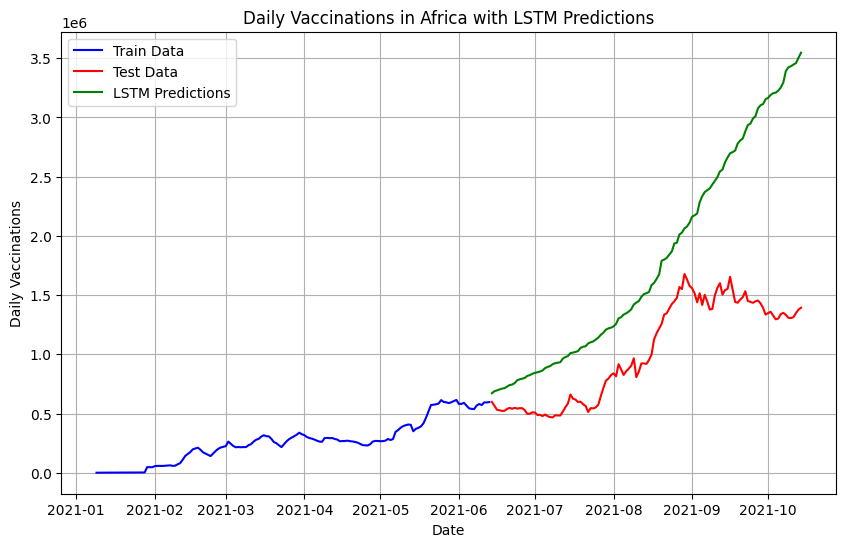

Training and testing LSTM for Asia
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


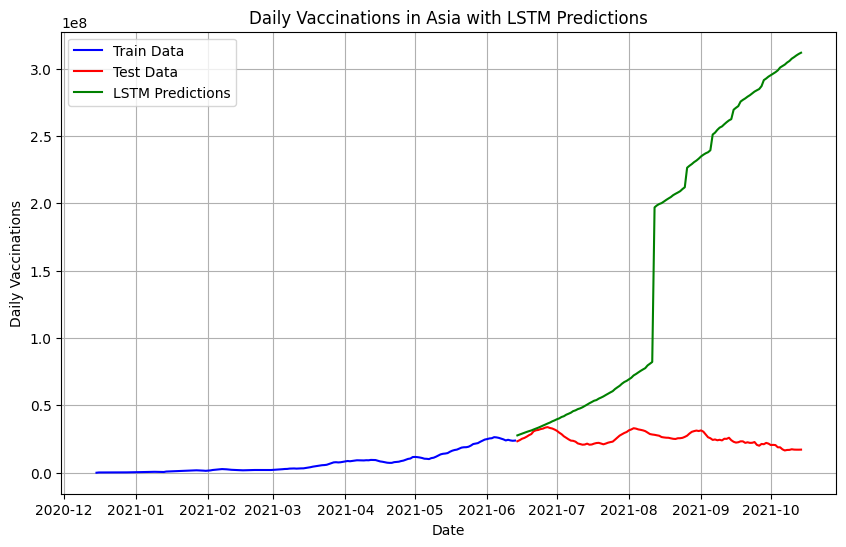

Training and testing LSTM for Europe
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


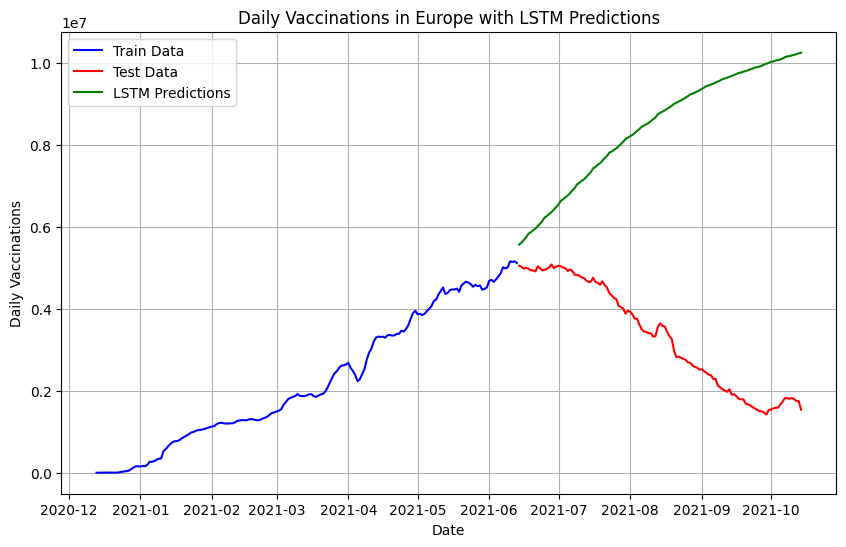

Training and testing LSTM for European Union
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


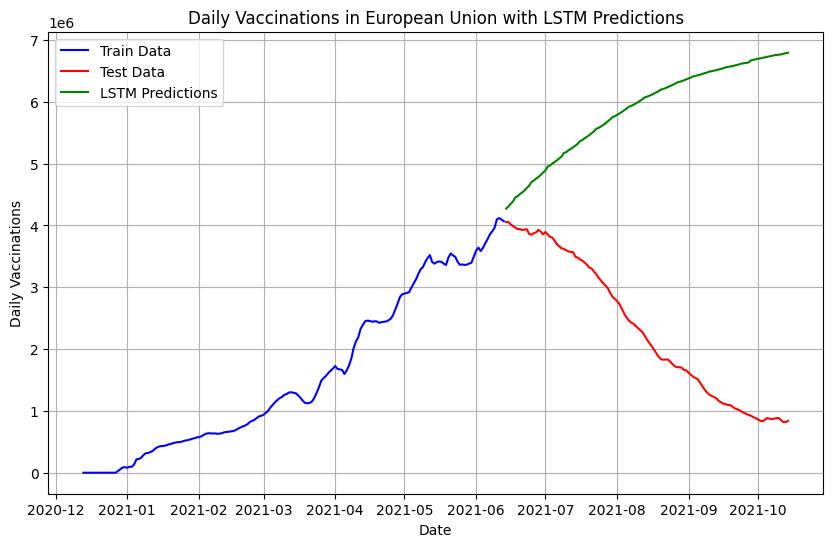

Training and testing LSTM for North America
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


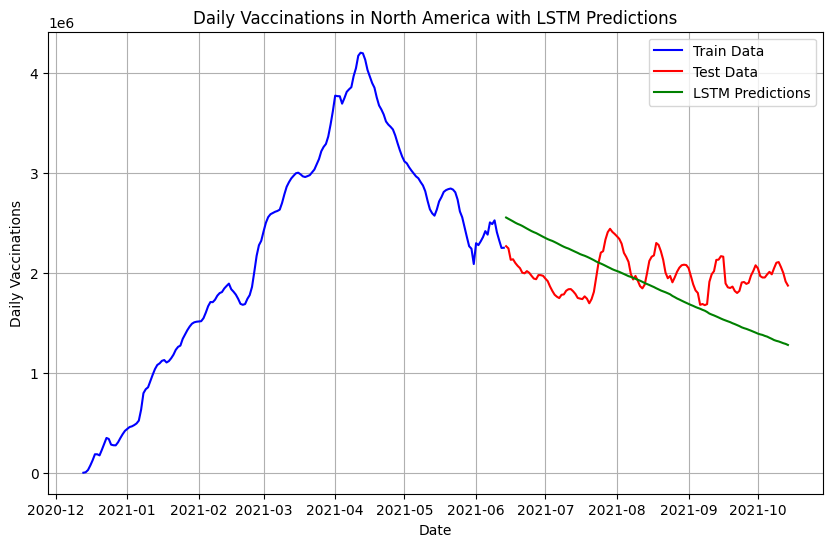

Training and testing LSTM for Oceania
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


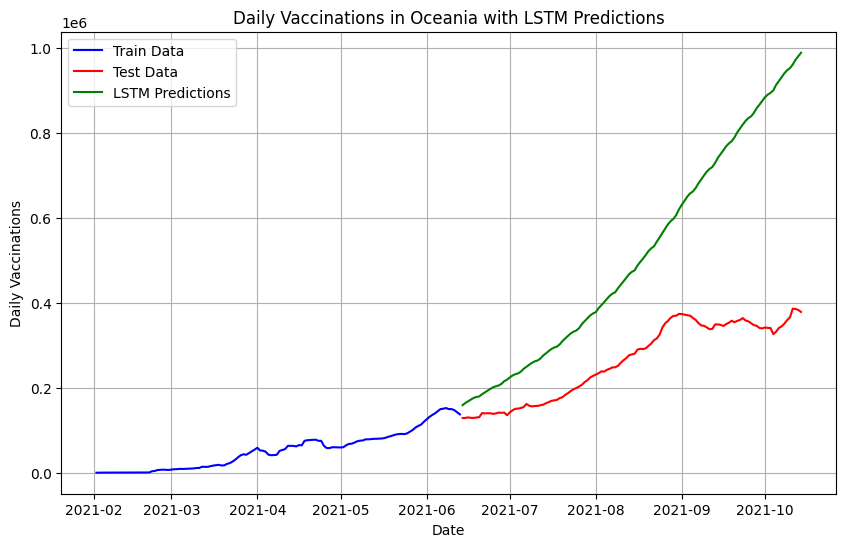

Training and testing LSTM for South America
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


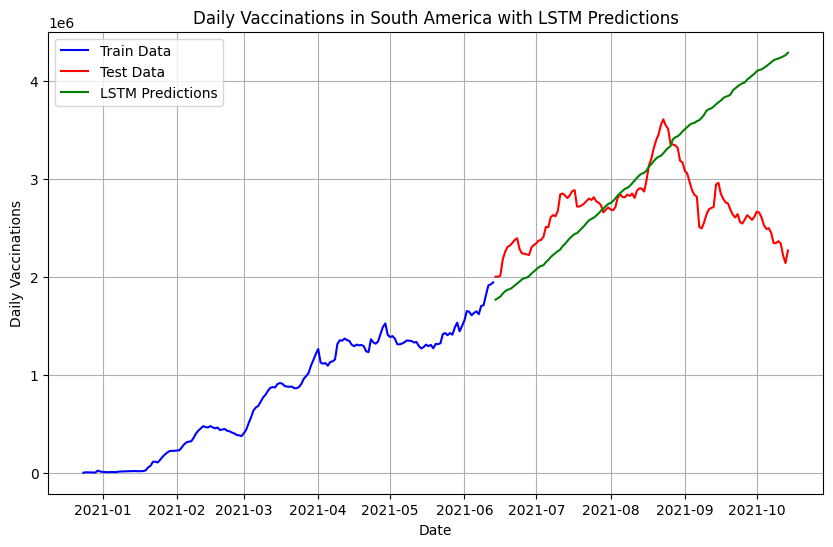

Training and testing LSTM for World
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


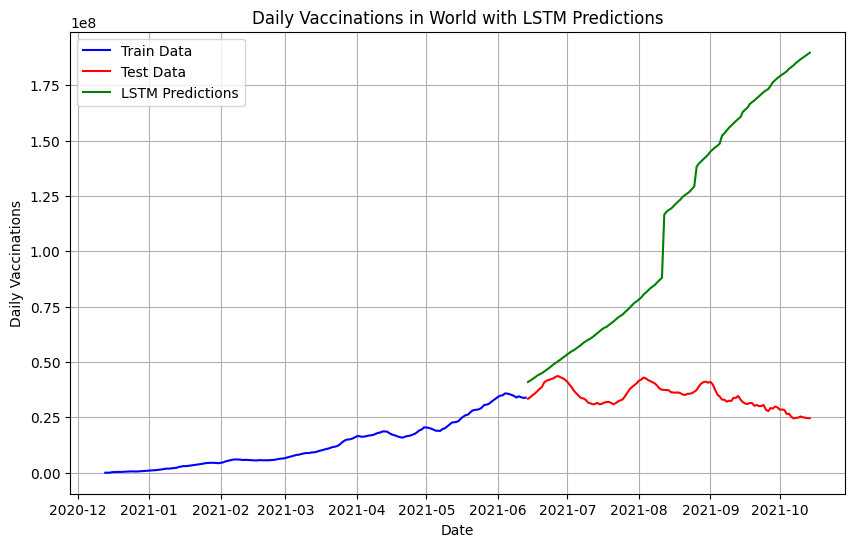

LSTM RAE DataFrame:
                               RAE
LSTM_Africa_RAE           1.993031
LSTM_Asia_RAE            35.584938
LSTM_Europe_RAE           4.361317
LSTM_European Union_RAE   3.458573
LSTM_North America_RAE    2.712877
LSTM_Oceania_RAE          3.035555
LSTM_South America_RAE    2.401759
LSTM_World_RAE           18.092918

LSTM MSLE DataFrame:
                              MSLE
LSTM_Africa_MSLE          0.325661
LSTM_Asia_MSLE            3.254859
LSTM_Europe_MSLE          1.365138
LSTM_European Union_MSLE  1.578680
LSTM_North America_MSLE   0.051217
LSTM_Oceania_MSLE         0.397773
LSTM_South America_MSLE   0.072431
LSTM_World_MSLE           1.488812

LSTM MASE DataFrame:
                                  MASE
LSTM_Africa_MASE          1.246965e+07
LSTM_Asia_MASE            4.281545e+09
LSTM_Europe_MASE          1.861160e+08
LSTM_European Union_MASE  1.428666e+08
LSTM_North America_MASE   8.899997e+06
LSTM_Oceania_MASE         5.665161e+06
LSTM_South America_MASE   1.39802

In [108]:
# prompt: train and  test for LSTM for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

lstm_continent_rae = {}
lstm_continent_msle = {}
lstm_continent_mase = {}
lstm_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing LSTM for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for LSTM
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_X = scaler_X.transform(test_X)
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    # Reshape input to be [samples, time steps, features] (assuming 1 time step)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(train_X, train_y, epochs=50, verbose=0)

    # Make predictions
    predictions = model.predict(test_X)

    # Inverse transform the predictions
    predictions = scaler_y.inverse_transform(predictions)
    test_y = scaler_y.inverse_transform(test_y)


    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    lstm_continent_rae[f'LSTM_{continent}_RAE'] = rae
    lstm_continent_msle[f'LSTM_{continent}_MSLE'] = msle
    lstm_continent_mase[f'LSTM_{continent}_MASE'] = mase
    lstm_continent_predictions[f'LSTM_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='LSTM Predictions')

    plt.title(f'Daily Vaccinations in {continent} with LSTM Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
lstm_rae_df = pd.DataFrame.from_dict(lstm_continent_rae, orient='index', columns=['RAE'])
lstm_msle_df = pd.DataFrame.from_dict(lstm_continent_msle, orient='index', columns=['MSLE'])
lstm_mase_df = pd.DataFrame.from_dict(lstm_continent_mase, orient='index', columns=['MASE'])


print("LSTM RAE DataFrame:")
print(lstm_rae_df)

print("\nLSTM MSLE DataFrame:")
print(lstm_msle_df)

print("\nLSTM MASE DataFrame:")
print(lstm_mase_df)



Training and testing Exponential Smoothing for Africa


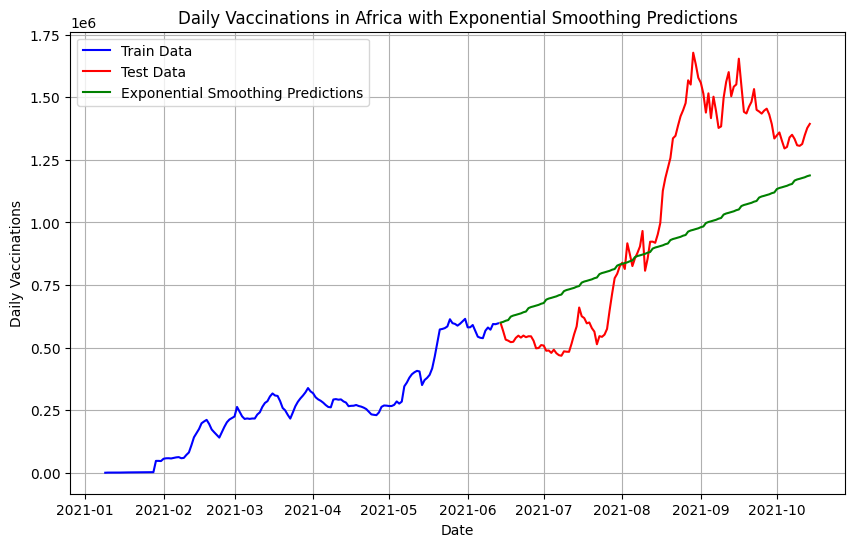

Training and testing Exponential Smoothing for Asia


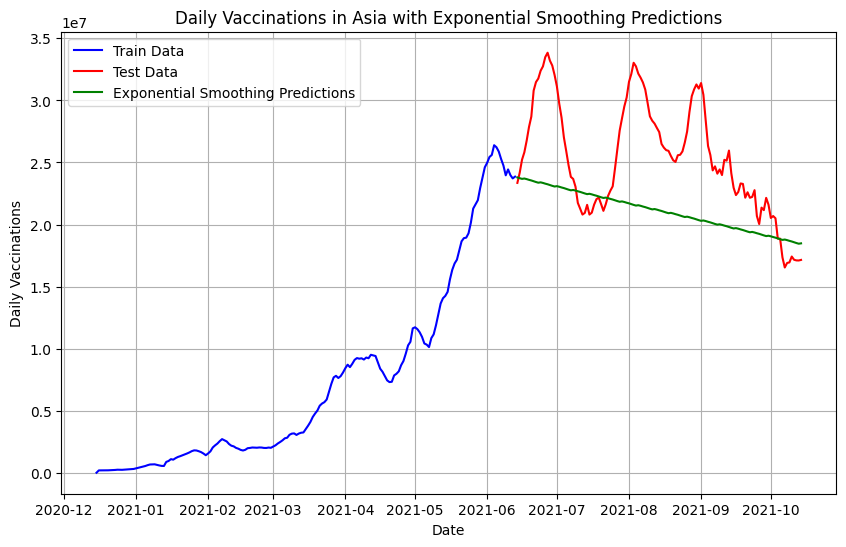

Training and testing Exponential Smoothing for Europe


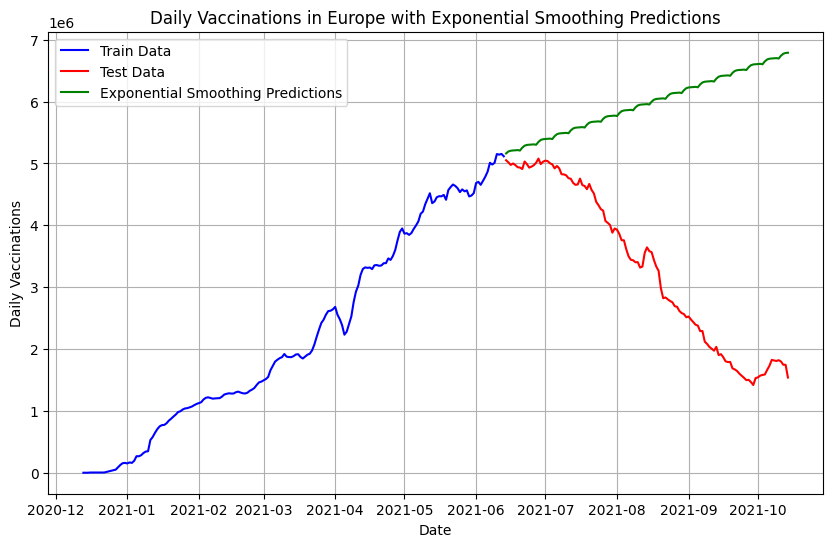

Training and testing Exponential Smoothing for European Union


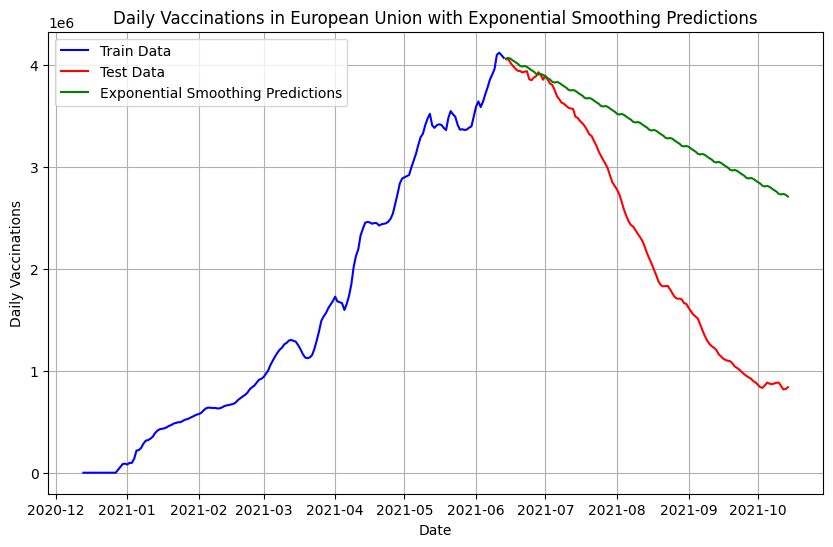

Training and testing Exponential Smoothing for North America


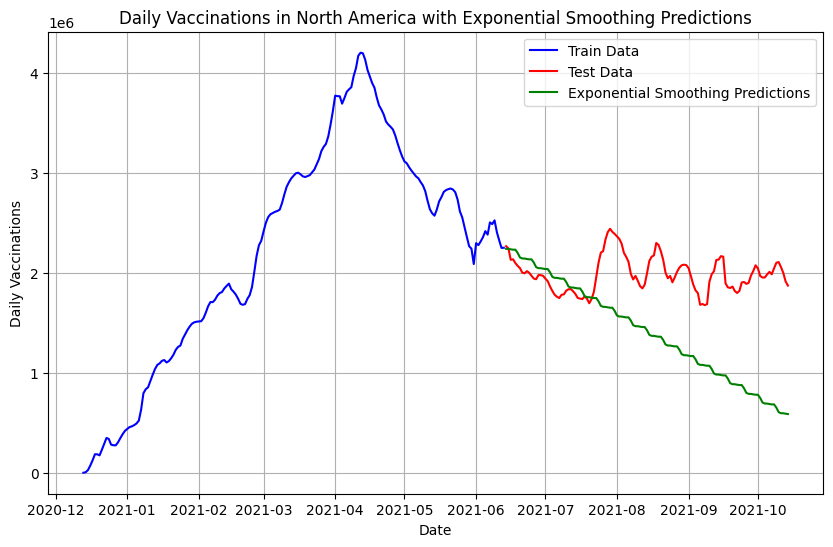

Training and testing Exponential Smoothing for Oceania


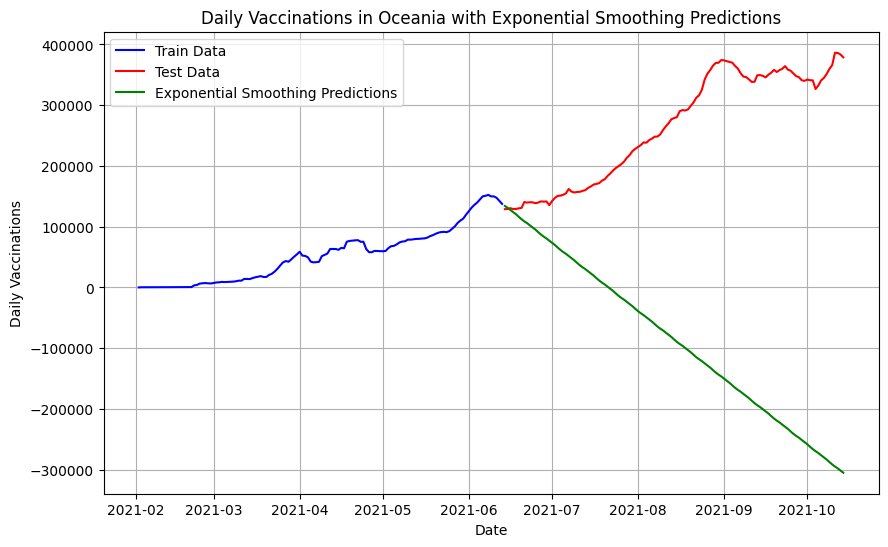

Training and testing Exponential Smoothing for South America


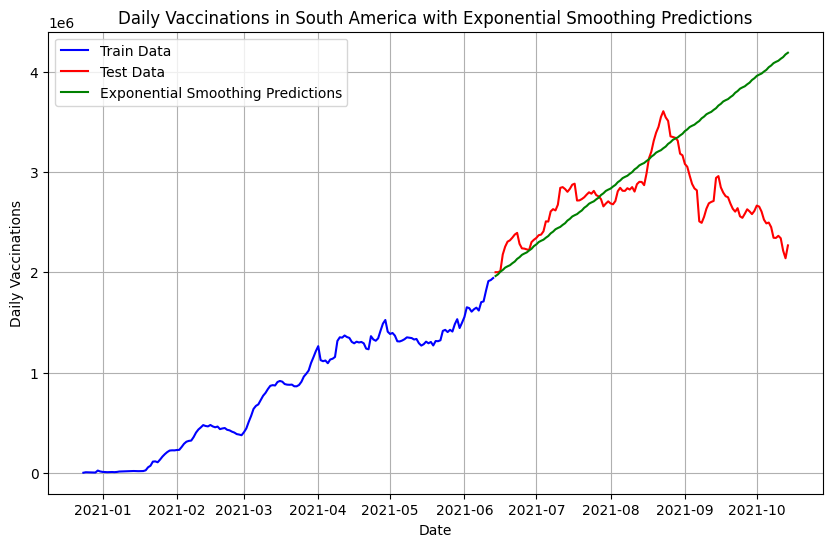

Training and testing Exponential Smoothing for World


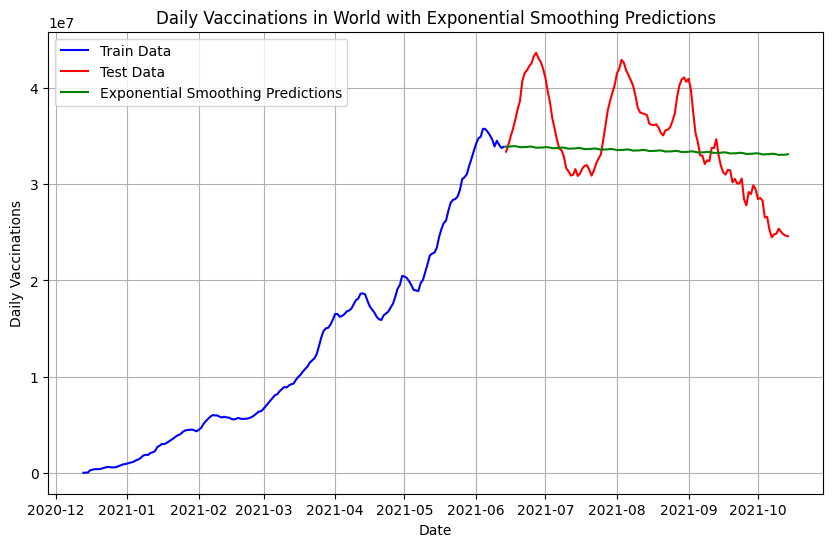

Exponential Smoothing RAE DataFrame:
                            RAE
ES_Africa_RAE          0.627755
ES_Asia_RAE            1.244972
ES_Europe_RAE          2.263630
ES_European Union_RAE  1.037019
ES_North America_RAE   4.565927
ES_Oceania_RAE         4.222588
ES_South America_RAE   2.024835
ES_World_RAE           0.988787

Exponential Smoothing MSLE DataFrame:
                              MSLE
ES_Africa_MSLE            0.082022
ES_Asia_MSLE              0.051926
ES_Europe_MSLE            0.710418
ES_European Union_MSLE    0.449322
ES_North America_MSLE     0.312880
ES_Oceania_MSLE         111.186334
ES_South America_MSLE     0.058448
ES_World_MSLE             0.021922

Exponential Smoothing MASE DataFrame:
                              MASE
ES_Africa_MASE           22.181695
ES_Asia_MASE             19.855063
ES_Europe_MASE           60.431397
ES_European Union_MASE   33.548713
ES_North America_MASE    13.323436
ES_Oceania_MASE         178.614597
ES_South America_MASE    20.602325
ES

In [109]:
# prompt: train and  test for Exponential Smoothing for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es_continent_rae = {}
es_continent_msle = {}
es_continent_mase = {}
es_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Exponential Smoothing for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Exponential Smoothing
    train_target = train_data['daily_vaccinations']
    test_target = test_data['daily_vaccinations']

    # Fit the Exponential Smoothing model
    try:
        model = ExponentialSmoothing(train_target, trend='add', seasonal='add', seasonal_periods=7)  # You can adjust the parameters
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = model_fit.predict(start=len(train_target), end=len(train_target) + len(test_target) - 1)

        # Calculate metrics
        rae = relative_absolute_error(test_target, predictions)
        msle = mean_squared_log_error(test_target, predictions)
        mase = mean_absolute_scaled_error(test_target, predictions, train_target)

        # Store the metrics
        es_continent_rae[f'ES_{continent}_RAE'] = rae
        es_continent_msle[f'ES_{continent}_MSLE'] = msle
        es_continent_mase[f'ES_{continent}_MASE'] = mase
        es_continent_predictions[f'ES_{continent}_predictions'] = predictions


        # Plot the results
        plt.figure(figsize=(10, 6))

        # Plot the train data in blue
        plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

        # Plot the test data in red
        plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

        # Plot the predictions in green
        plt.plot(test_data['date'], predictions, color='green', label='Exponential Smoothing Predictions')

        plt.title(f'Daily Vaccinations in {continent} with Exponential Smoothing Predictions')
        plt.xlabel('Date')
        plt.ylabel('Daily Vaccinations')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error training Exponential Smoothing for {continent}: {e}")
        # Handle the error appropriately (e.g., log it or skip the continent)


# Create DataFrames for RAE, MSLE, and MASE
es_rae_df = pd.DataFrame.from_dict(es_continent_rae, orient='index', columns=['RAE'])
es_msle_df = pd.DataFrame.from_dict(es_continent_msle, orient='index', columns=['MSLE'])
es_mase_df = pd.DataFrame.from_dict(es_continent_mase, orient='index', columns=['MASE'])


# Create DataFrame for predictions
es_predictions_df = pd.DataFrame.from_dict(es_continent_predictions, orient='index', columns=['Predictions'])


print("Exponential Smoothing RAE DataFrame:")
print(es_rae_df)

print("\nExponential Smoothing MSLE DataFrame:")
print(es_msle_df)

print("\nExponential Smoothing MASE DataFrame:")
print(es_mase_df)

print("\nExponential Smoothing Predictions DataFrame:")
print(es_predictions_df)


Training and testing XGBoost for Africa


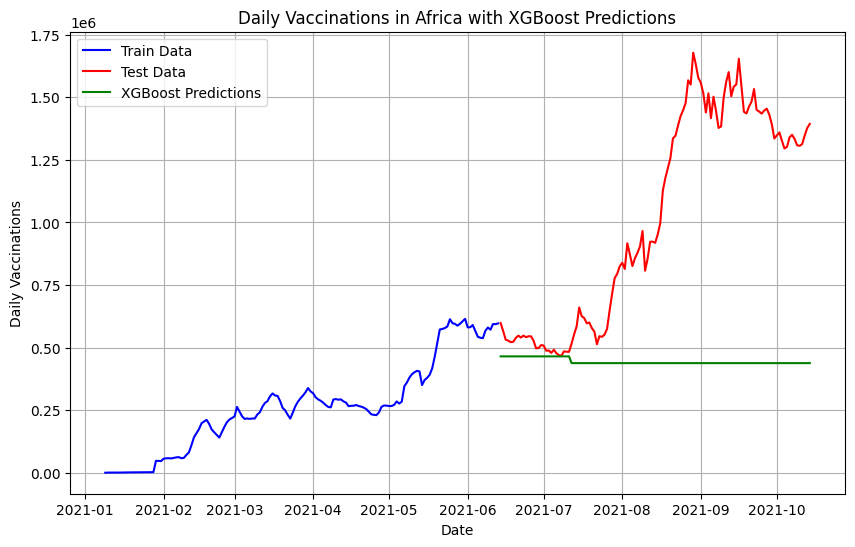

Training and testing XGBoost for Asia


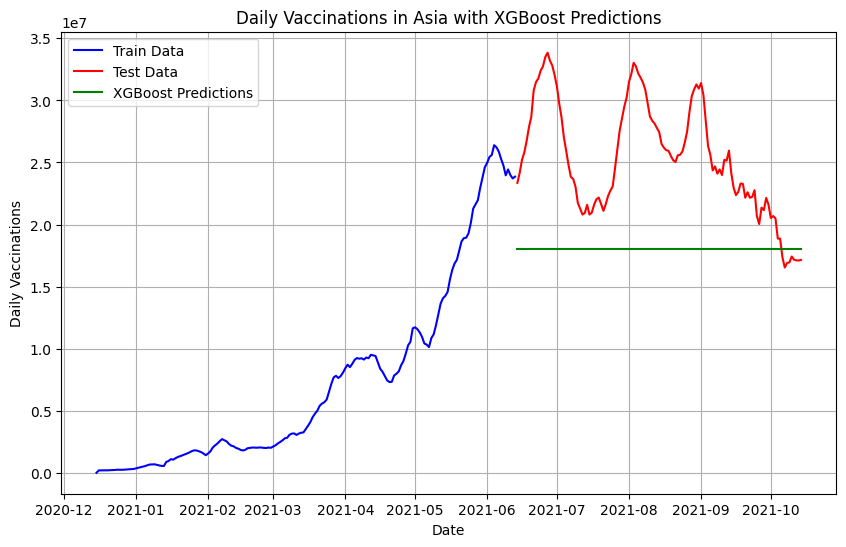

Training and testing XGBoost for Europe


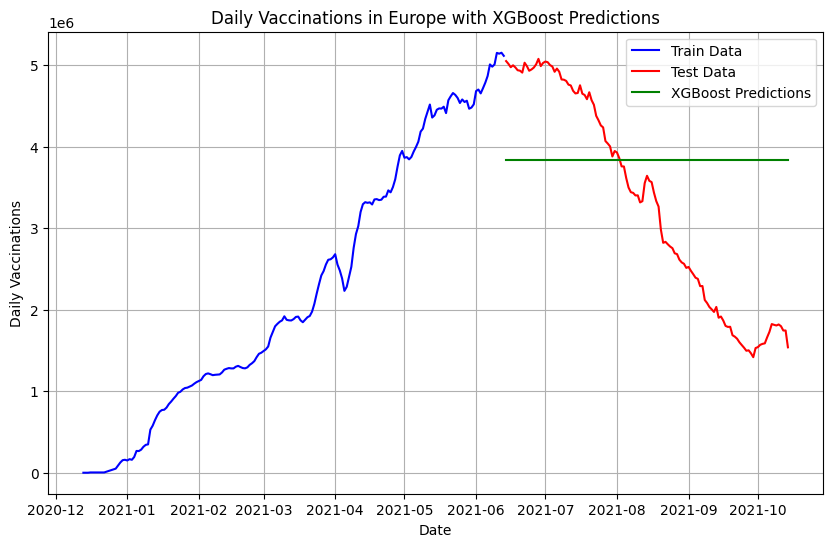

Training and testing XGBoost for European Union


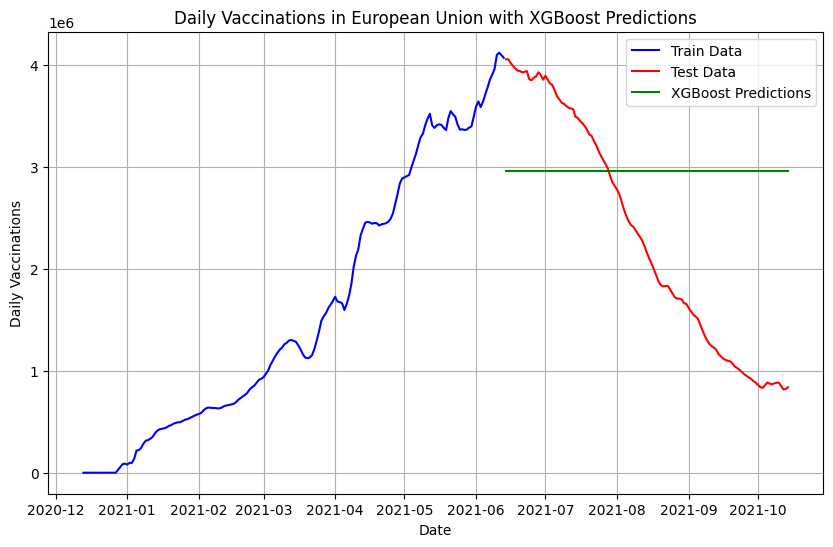

Training and testing XGBoost for North America


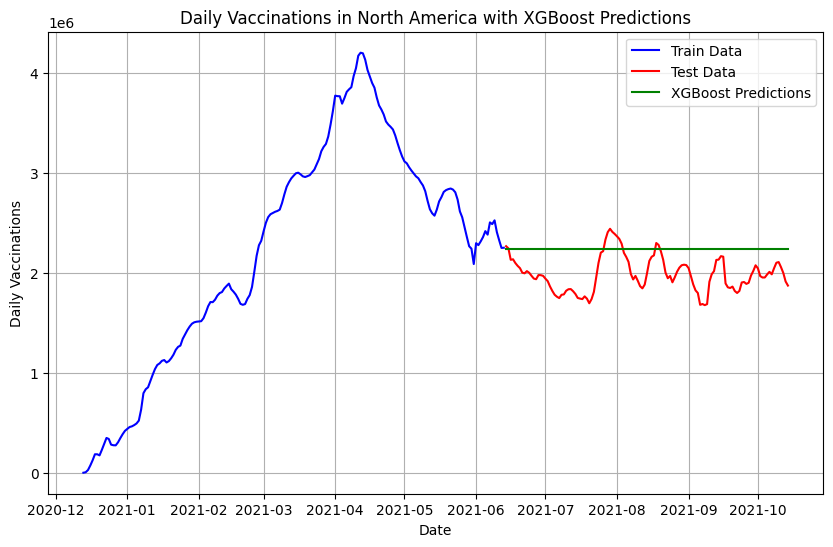

Training and testing XGBoost for Oceania


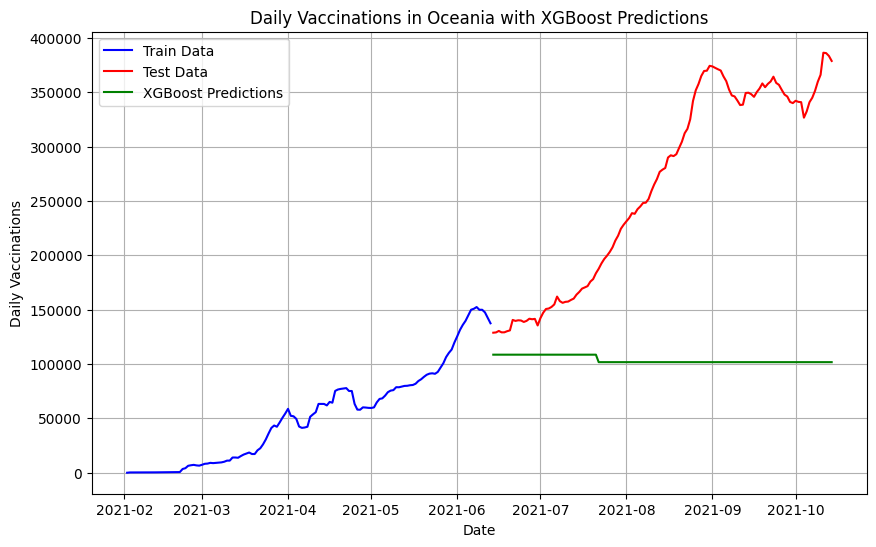

Training and testing XGBoost for South America


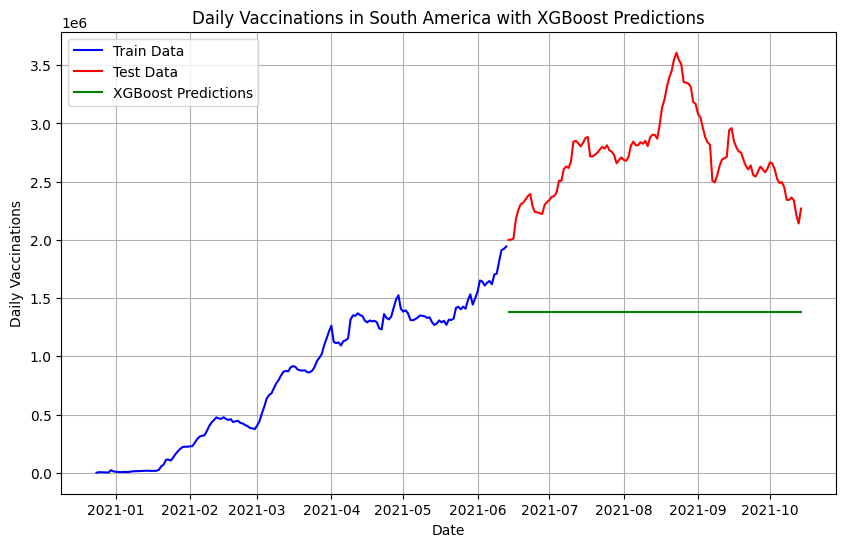

Training and testing XGBoost for World


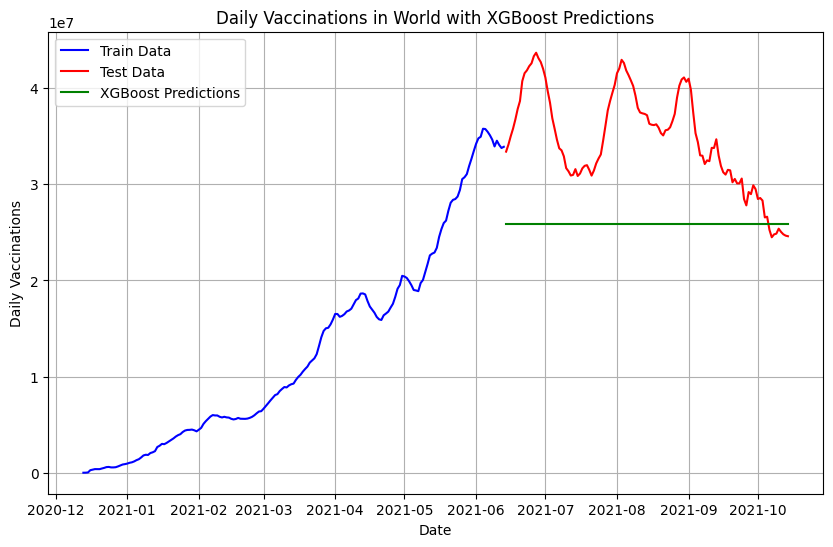

XGBoost RAE DataFrame:
                                 RAE
XGBoost_Africa_RAE          1.464056
XGBoost_Asia_RAE            1.990823
XGBoost_Europe_RAE          1.040876
XGBoost_European Union_RAE  1.108463
XGBoost_North America_RAE   1.983732
XGBoost_Oceania_RAE         1.931908
XGBoost_South America_RAE   5.168953
XGBoost_World_RAE           2.101189

XGBoost MSLE DataFrame:
                                 MSLE
XGBoost_Africa_MSLE          0.760158
XGBoost_Asia_MSLE            0.138447
XGBoost_Europe_MSLE          0.240308
XGBoost_European Union_MSLE  0.450624
XGBoost_North America_MSLE   0.023036
XGBoost_Oceania_MSLE         0.912977
XGBoost_South America_MSLE   0.453476
XGBoost_World_MSLE           0.102441

XGBoost MASE DataFrame:
                                  MASE
XGBoost_Africa_MASE          51.732329
XGBoost_Asia_MASE            31.750040
XGBoost_Europe_MASE          27.787917
XGBoost_European Union_MASE  35.860011
XGBoost_North America_MASE    5.788556
XGBoost_Oceania_MA

In [111]:
# prompt: train and  test for XGBoost for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ... (Your existing code for importing data and defining metrics) ...

xgboost_continent_rae = {}
xgboost_continent_msle = {}
xgboost_continent_mase = {}
xgboost_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing XGBoost for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for XGBoost
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create XGBoost model
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    xgboost_continent_rae[f'XGBoost_{continent}_RAE'] = rae
    xgboost_continent_msle[f'XGBoost_{continent}_MSLE'] = msle
    xgboost_continent_mase[f'XGBoost_{continent}_MASE'] = mase
    xgboost_continent_predictions[f'XGBoost_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='XGBoost Predictions')

    plt.title(f'Daily Vaccinations in {continent} with XGBoost Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
xgboost_rae_df = pd.DataFrame.from_dict(xgboost_continent_rae, orient='index', columns=['RAE'])
xgboost_msle_df = pd.DataFrame.from_dict(xgboost_continent_msle, orient='index', columns=['MSLE'])
xgboost_mase_df = pd.DataFrame.from_dict(xgboost_continent_mase, orient='index', columns=['MASE'])


print("XGBoost RAE DataFrame:")
print(xgboost_rae_df)

print("\nXGBoost MSLE DataFrame:")
print(xgboost_msle_df)

print("\nXGBoost MASE DataFrame:")
print(xgboost_mase_df)



Training and testing LightGBM for Africa


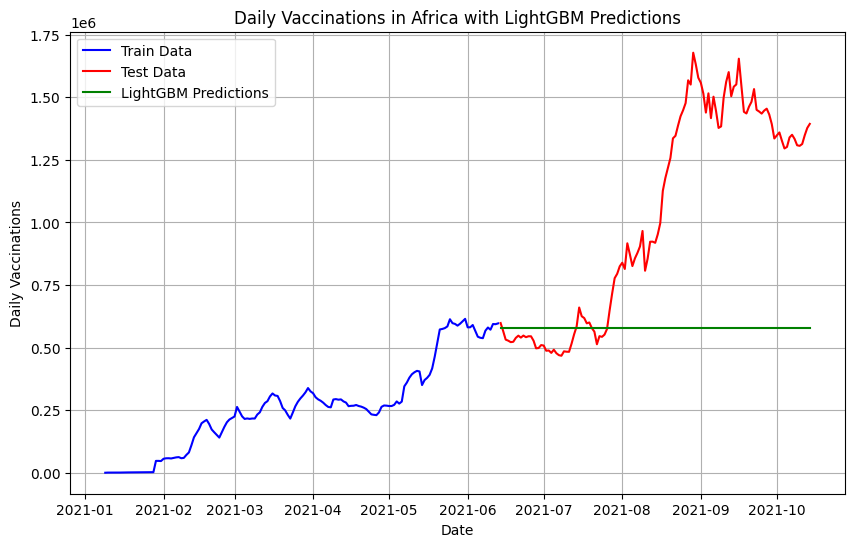

Training and testing LightGBM for Asia


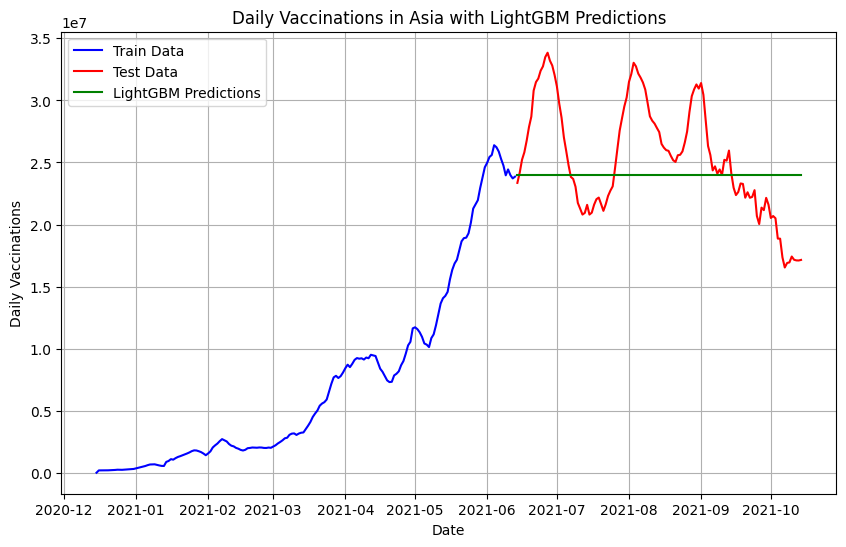

Training and testing LightGBM for Europe


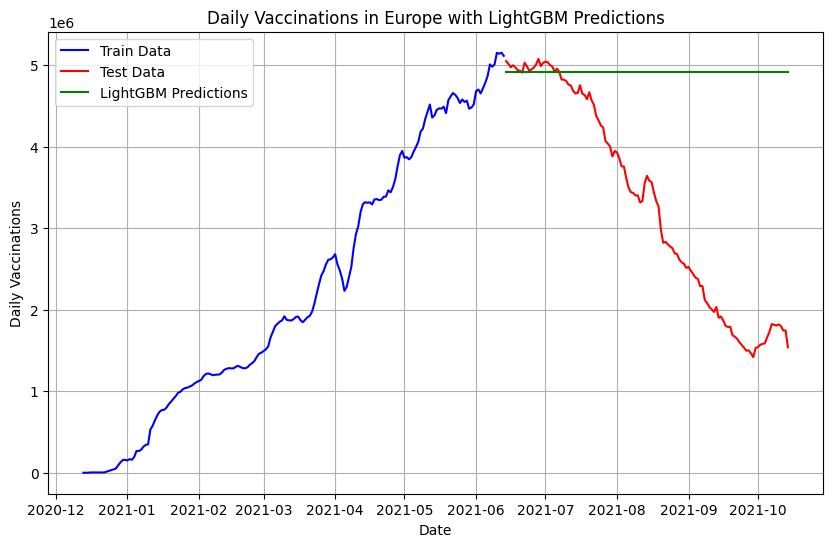

Training and testing LightGBM for European Union


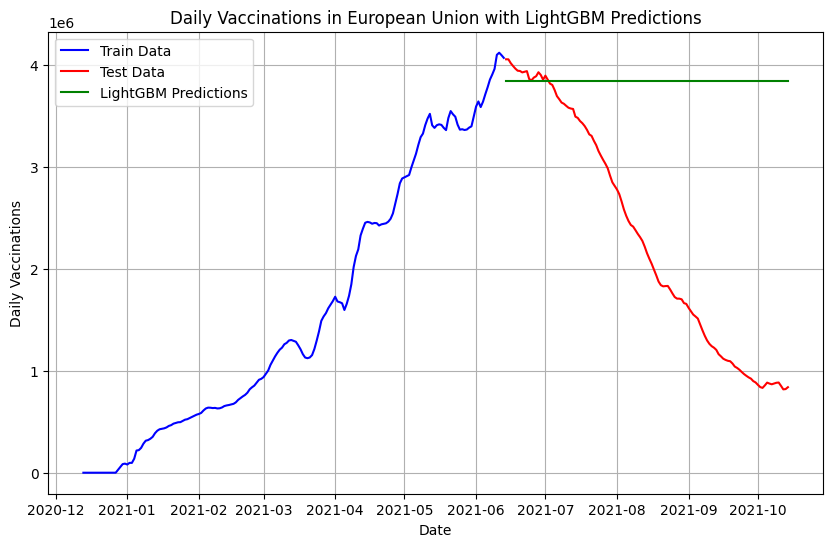

Training and testing LightGBM for North America


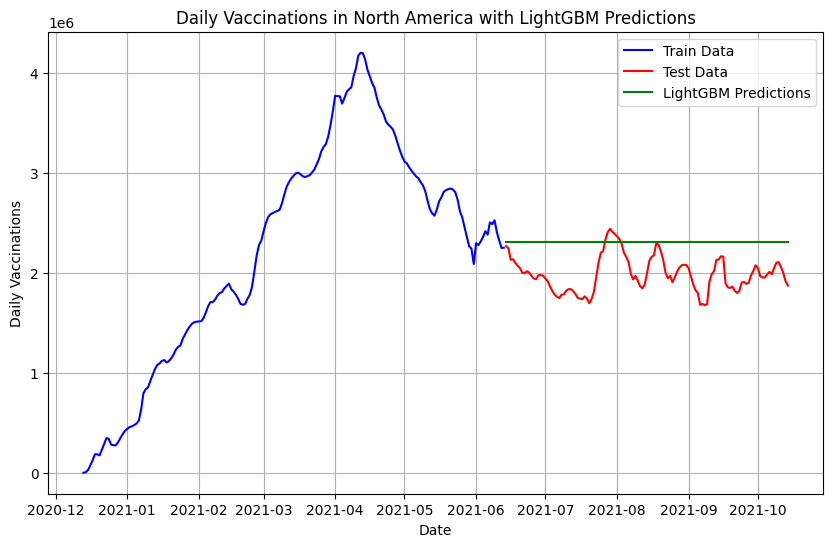

Training and testing LightGBM for Oceania


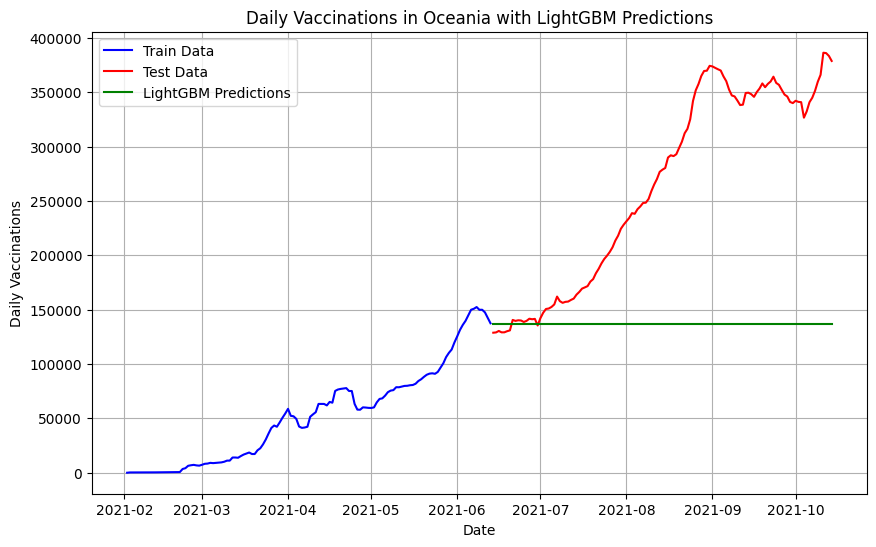

Training and testing LightGBM for South America


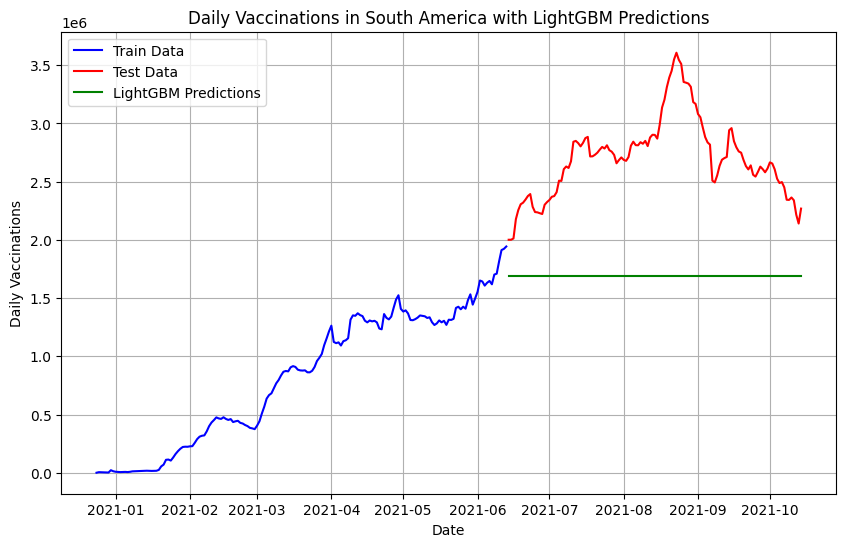

Training and testing LightGBM for World


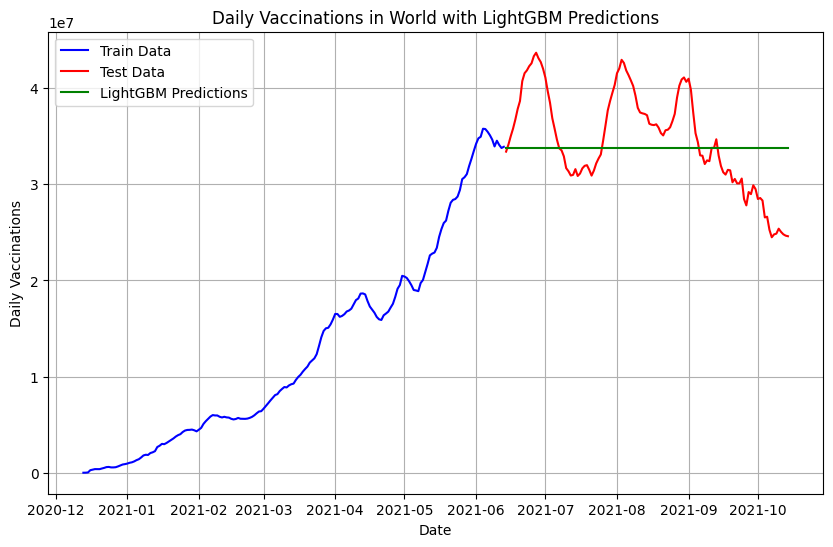

LightGBM RAE DataFrame:
                                  RAE
LightGBM_Africa_RAE          1.207255
LightGBM_Asia_RAE            1.023361
LightGBM_Europe_RAE          1.387884
LightGBM_European Union_RAE  1.506531
LightGBM_North America_RAE   2.399674
LightGBM_Oceania_RAE         1.546372
LightGBM_South America_RAE   3.976185
LightGBM_World_RAE           1.008661

LightGBM MSLE DataFrame:
                                  MSLE
LightGBM_Africa_MSLE          0.424872
LightGBM_Asia_MSLE            0.034503
LightGBM_Europe_MSLE          0.417816
LightGBM_European Union_MSLE  0.719101
LightGBM_North America_MSLE   0.031370
LightGBM_Oceania_MSLE         0.492857
LightGBM_South America_MSLE   0.229749
LightGBM_World_MSLE           0.023034

LightGBM MASE DataFrame:
                                   MASE
LightGBM_Africa_MASE          42.658272
LightGBM_Asia_MASE            16.320769
LightGBM_Europe_MASE          37.051898
LightGBM_European Union_MASE  48.737958
LightGBM_North America_MASE    

In [116]:
# prompt: train and  test for LightGBM for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test and turn off all LightGBM  warnings

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Turn off LightGBM warnings

lightgbm_continent_rae = {}
lightgbm_continent_msle = {}
lightgbm_continent_mase = {}
lightgbm_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing LightGBM for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for LightGBM
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create LightGBM model
    model = lgb.LGBMRegressor(verbose=-1)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    lightgbm_continent_rae[f'LightGBM_{continent}_RAE'] = rae
    lightgbm_continent_msle[f'LightGBM_{continent}_MSLE'] = msle
    lightgbm_continent_mase[f'LightGBM_{continent}_MASE'] = mase
    lightgbm_continent_predictions[f'LightGBM_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='LightGBM Predictions')

    plt.title(f'Daily Vaccinations in {continent} with LightGBM Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
lightgbm_rae_df = pd.DataFrame.from_dict(lightgbm_continent_rae, orient='index', columns=['RAE'])
lightgbm_msle_df = pd.DataFrame.from_dict(lightgbm_continent_msle, orient='index', columns=['MSLE'])
lightgbm_mase_df = pd.DataFrame.from_dict(lightgbm_continent_mase, orient='index', columns=['MASE'])

print("LightGBM RAE DataFrame:")
print(lightgbm_rae_df)

print("\nLightGBM MSLE DataFrame:")
print(lightgbm_msle_df)

print("\nLightGBM MASE DataFrame:")
print(lightgbm_mase_df)


Training and testing Elastic Net for Africa


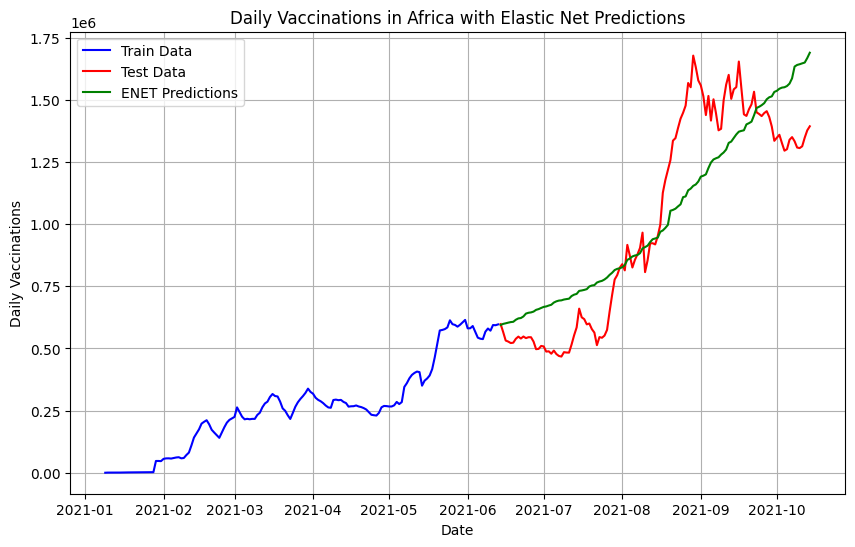

Training and testing Elastic Net for Asia


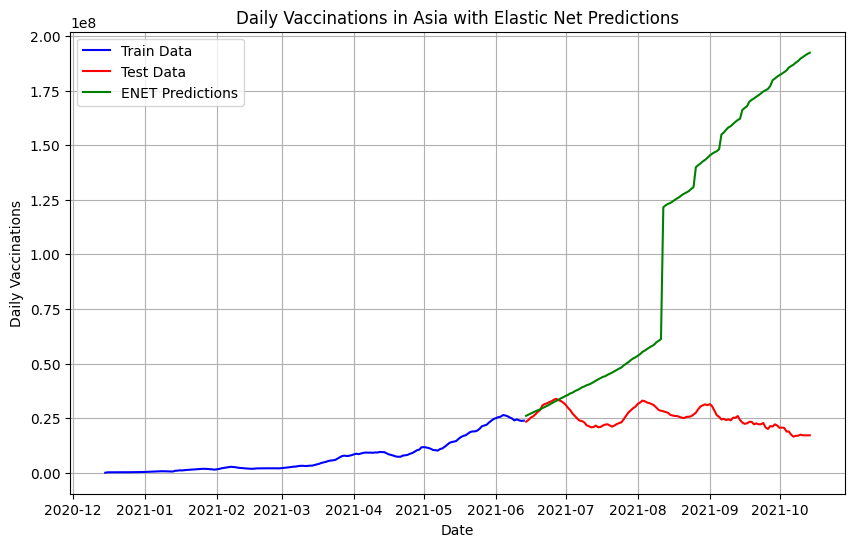

Training and testing Elastic Net for Europe


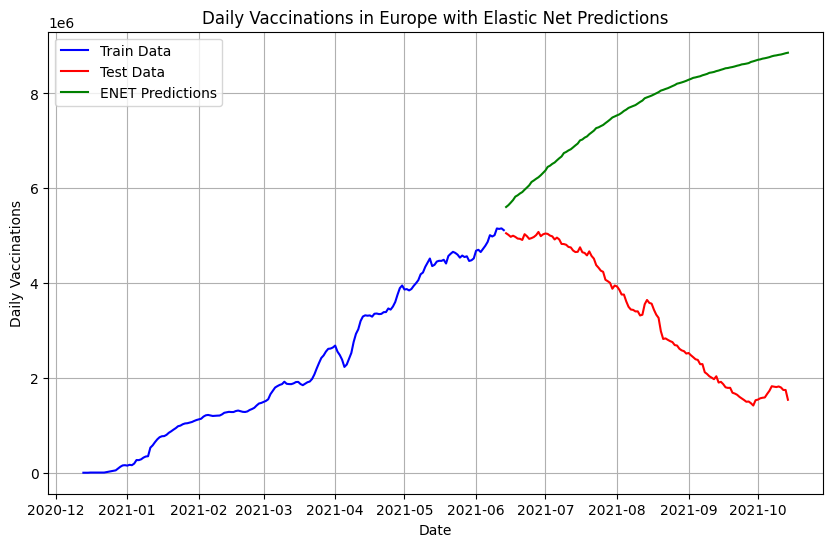

Training and testing Elastic Net for European Union


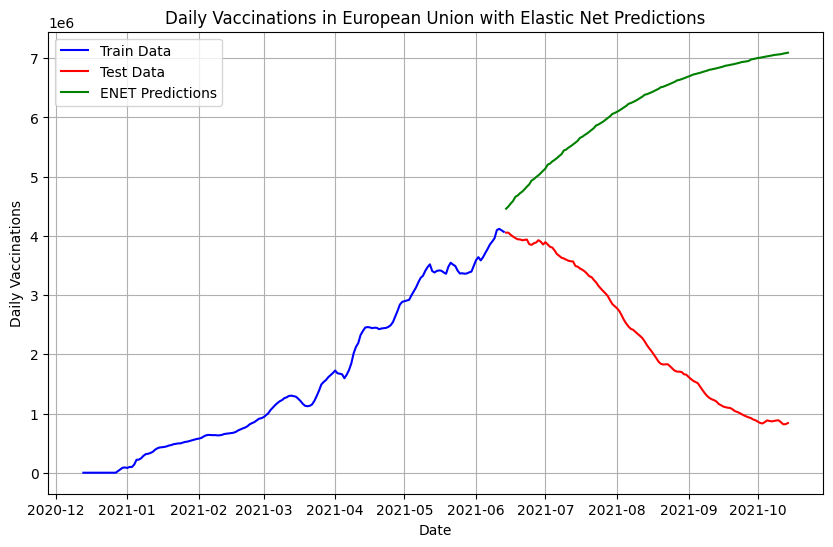

Training and testing Elastic Net for North America


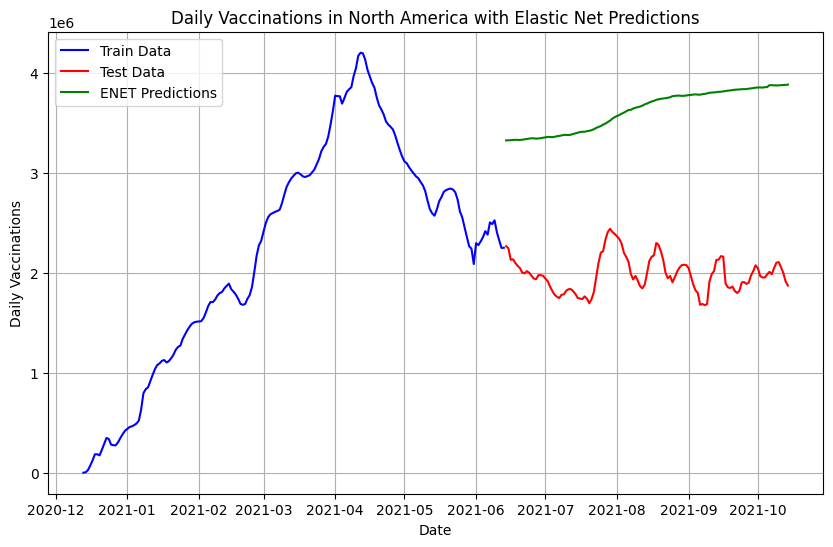

Training and testing Elastic Net for Oceania


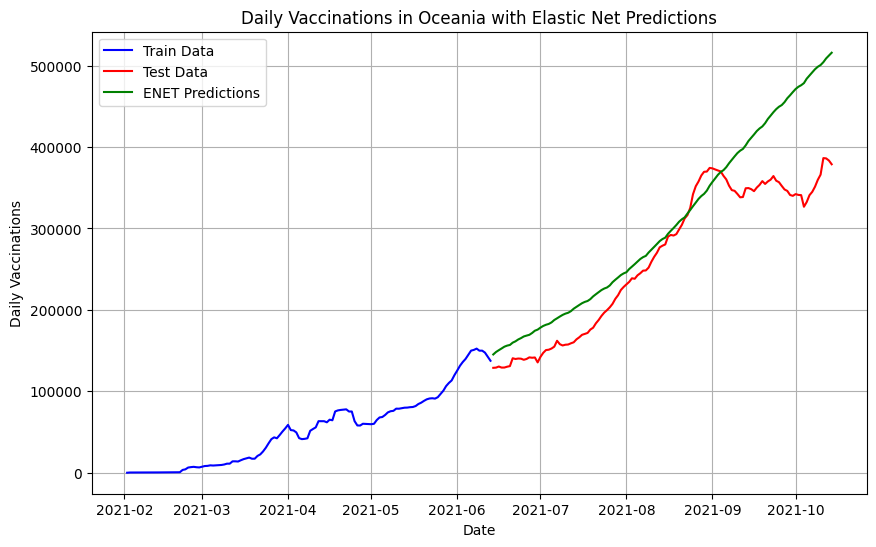

Training and testing Elastic Net for South America


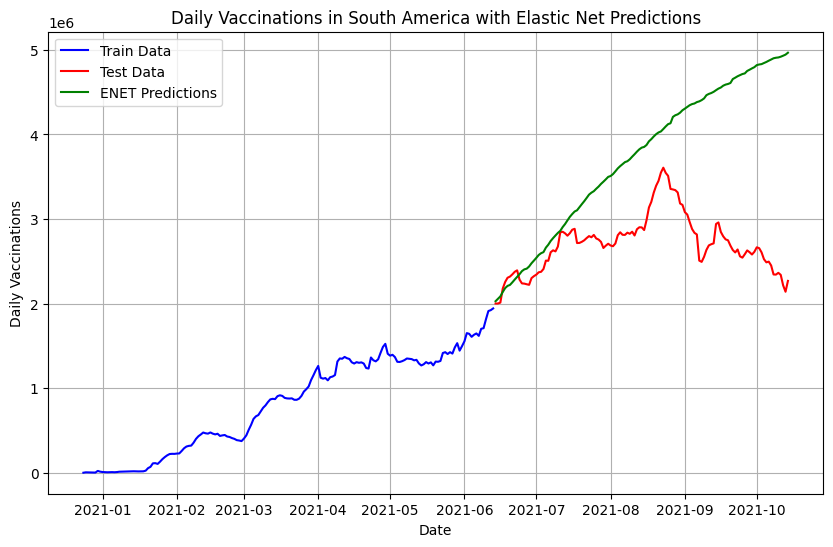

Training and testing Elastic Net for World


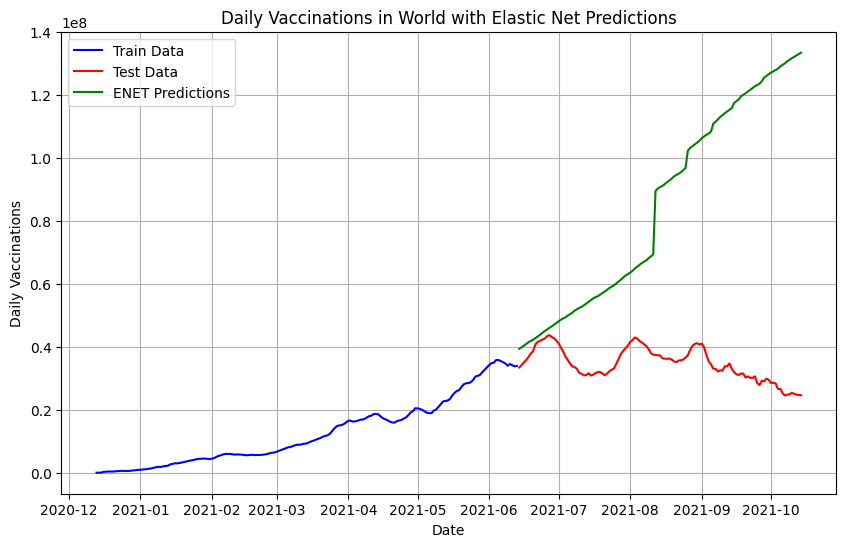

Elastic Net RAE DataFrame:
                               RAE
ENET_Africa_RAE           0.424963
ENET_Asia_RAE            20.756712
ENET_Europe_RAE           3.699529
ENET_European Union_RAE   3.742875
ENET_North America_RAE   11.878840
ENET_Oceania_RAE          0.553246
ENET_South America_RAE    4.046518
ENET_World_RAE           11.796352

Elastic Net MSLE DataFrame:
                              MSLE
ENET_Africa_MSLE          0.041994
ENET_Asia_MSLE            2.069554
ENET_Europe_MSLE          1.141708
ENET_European Union_MSLE  1.682302
ENET_North America_MSLE   0.375058
ENET_Oceania_MSLE         0.033332
ENET_South America_MSLE   0.143221
ENET_World_MSLE           0.940107

Elastic Net MASE DataFrame:
                                MASE
ENET_Africa_MASE           15.016035
ENET_Asia_MASE            331.032104
ENET_Europe_MASE           98.765132
ENET_European Union_MASE  121.086200
ENET_North America_MASE    34.662611
ENET_Oceania_MASE          23.402176
ENET_South America_MASE   

In [117]:
# prompt: train and  test for Elastic Net (ENET)  for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
enet_continent_rae = {}
enet_continent_msle = {}
enet_continent_mase = {}
enet_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Elastic Net for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Elastic Net
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create Elastic Net model
    model = ElasticNet(alpha=0.1, l1_ratio=0.5)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    enet_continent_rae[f'ENET_{continent}_RAE'] = rae
    enet_continent_msle[f'ENET_{continent}_MSLE'] = msle
    enet_continent_mase[f'ENET_{continent}_MASE'] = mase
    enet_continent_predictions[f'ENET_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='ENET Predictions')

    plt.title(f'Daily Vaccinations in {continent} with Elastic Net Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
enet_rae_df = pd.DataFrame.from_dict(enet_continent_rae, orient='index', columns=['RAE'])
enet_msle_df = pd.DataFrame.from_dict(enet_continent_msle, orient='index', columns=['MSLE'])
enet_mase_df = pd.DataFrame.from_dict(enet_continent_mase, orient='index', columns=['MASE'])

print("Elastic Net RAE DataFrame:")
print(enet_rae_df)

print("\nElastic Net MSLE DataFrame:")
print(enet_msle_df)

print("\nElastic Net MASE DataFrame:")
print(enet_mase_df)


Training and testing Cubist for Africa


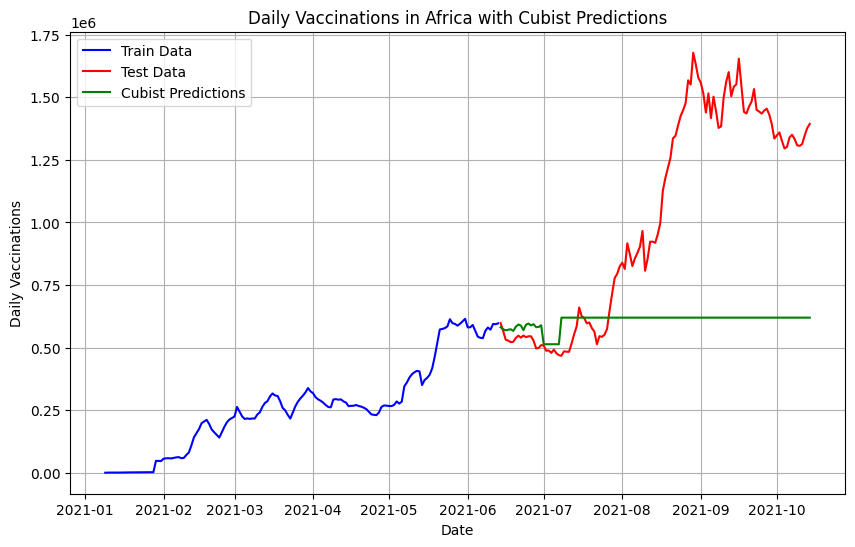

Training and testing Cubist for Asia


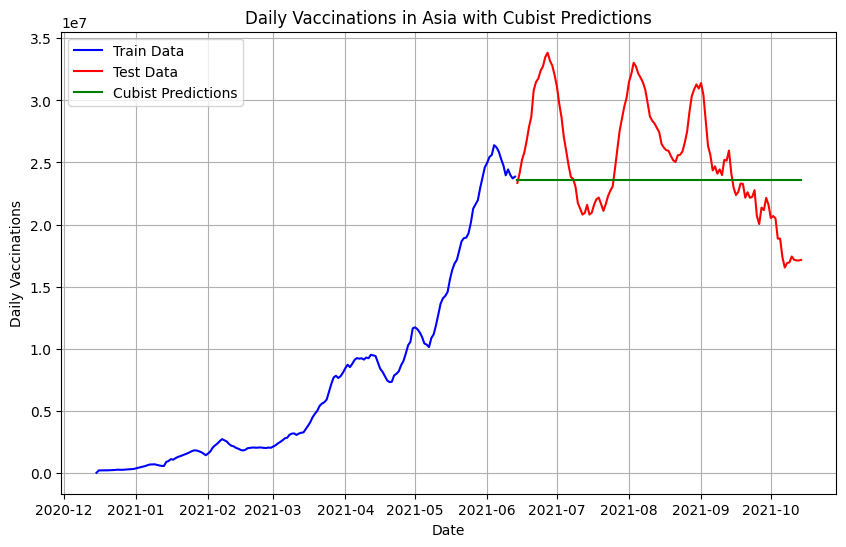

Training and testing Cubist for Europe


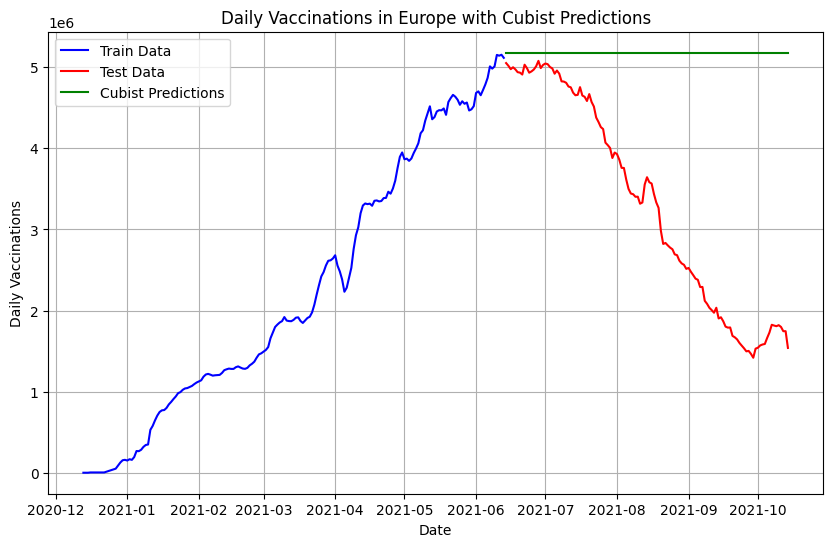

Training and testing Cubist for European Union


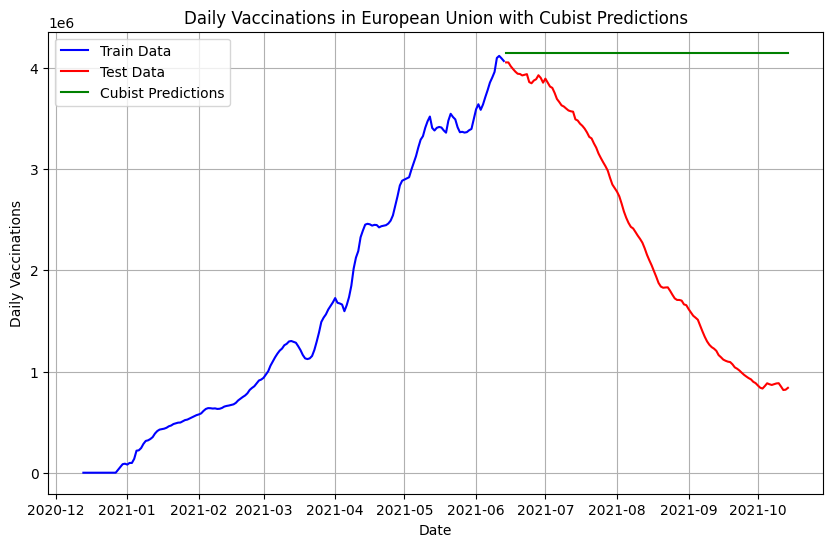

Training and testing Cubist for North America


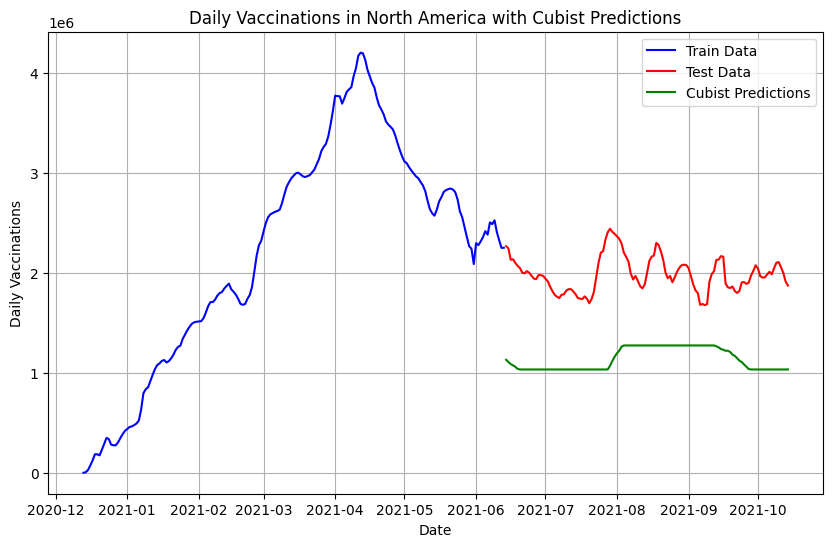

Training and testing Cubist for Oceania


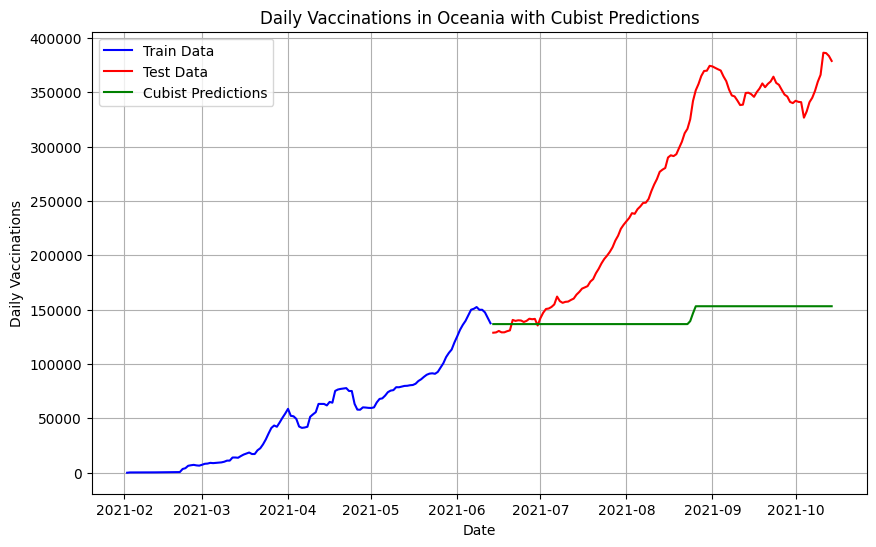

Training and testing Cubist for South America


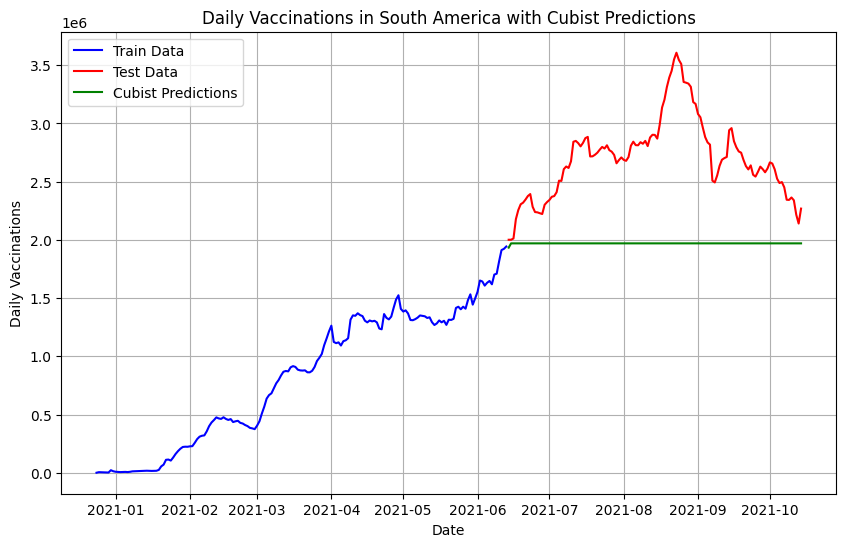

Training and testing Cubist for World


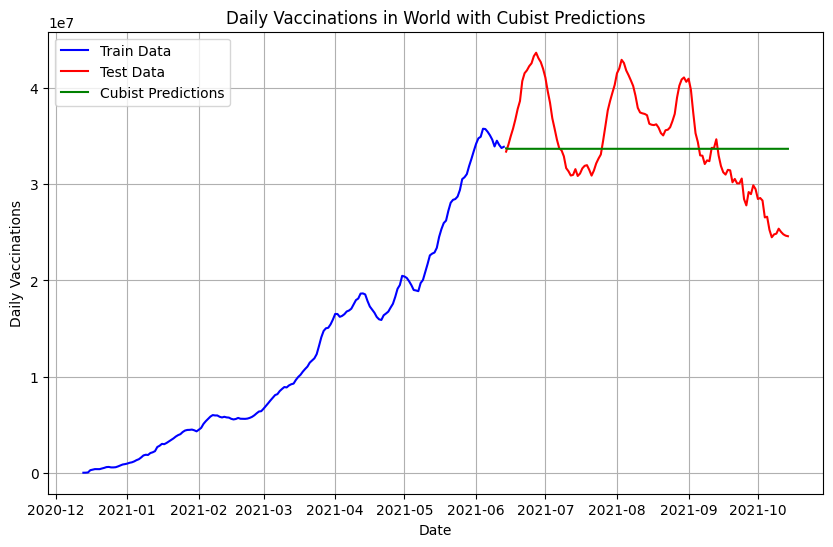

Cubist RAE DataFrame:
                                RAE
Cubist_Africa_RAE          1.139534
Cubist_Asia_RAE            1.046815
Cubist_Europe_RAE          1.587712
Cubist_European Union_RAE  1.778078
Cubist_North America_RAE   6.153694
Cubist_Oceania_RAE         1.462081
Cubist_South America_RAE   2.875679
Cubist_World_RAE           1.010364

Cubist MSLE DataFrame:
                                MSLE
Cubist_Africa_MSLE          0.359119
Cubist_Asia_MSLE            0.036242
Cubist_Europe_MSLE          0.470254
Cubist_European Union_MSLE  0.823606
Cubist_North America_MSLE   0.326362
Cubist_Oceania_MSLE         0.406845
Cubist_South America_MSLE   0.110809
Cubist_World_MSLE           0.023097

Cubist MASE DataFrame:
                                 MASE
Cubist_Africa_MASE          40.265365
Cubist_Asia_MASE            16.694815
Cubist_Europe_MASE          42.386642
Cubist_European Union_MASE  57.522817
Cubist_North America_MASE   17.956561
Cubist_Oceania_MASE         61.845738
Cubist_

In [118]:
# prompt: train and  test for CUBIST  for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from cubist import Cubist

cubist_continent_rae = {}
cubist_continent_msle = {}
cubist_continent_mase = {}
cubist_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Cubist for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Cubist
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create Cubist model
    model = Cubist()

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    cubist_continent_rae[f'Cubist_{continent}_RAE'] = rae
    cubist_continent_msle[f'Cubist_{continent}_MSLE'] = msle
    cubist_continent_mase[f'Cubist_{continent}_MASE'] = mase
    cubist_continent_predictions[f'Cubist_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='Cubist Predictions')

    plt.title(f'Daily Vaccinations in {continent} with Cubist Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
cubist_rae_df = pd.DataFrame.from_dict(cubist_continent_rae, orient='index', columns=['RAE'])
cubist_msle_df = pd.DataFrame.from_dict(cubist_continent_msle, orient='index', columns=['MSLE'])
cubist_mase_df = pd.DataFrame.from_dict(cubist_continent_mase, orient='index', columns=['MASE'])

print("Cubist RAE DataFrame:")
print(cubist_rae_df)

print("\nCubist MSLE DataFrame:")
print(cubist_msle_df)

print("\nCubist MASE DataFrame:")
print(cubist_mase_df)


Training and testing Gaussian Process for Africa


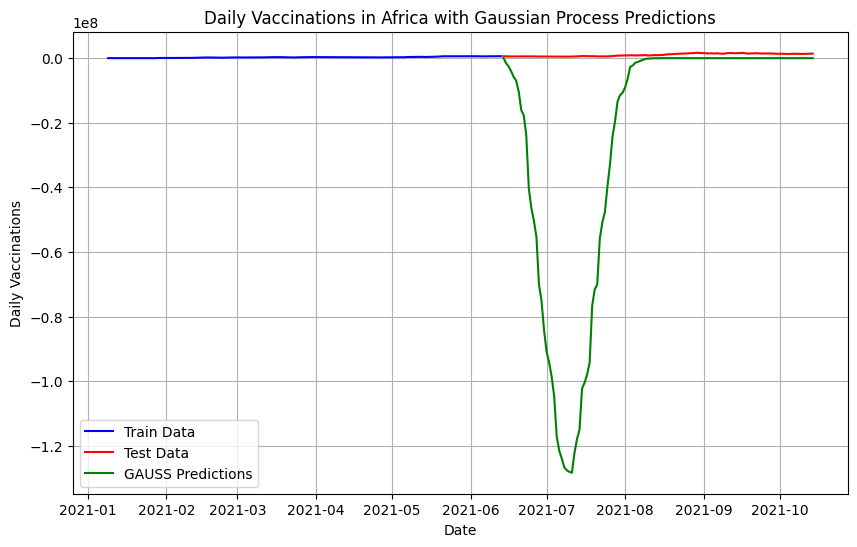

Training and testing Gaussian Process for Asia


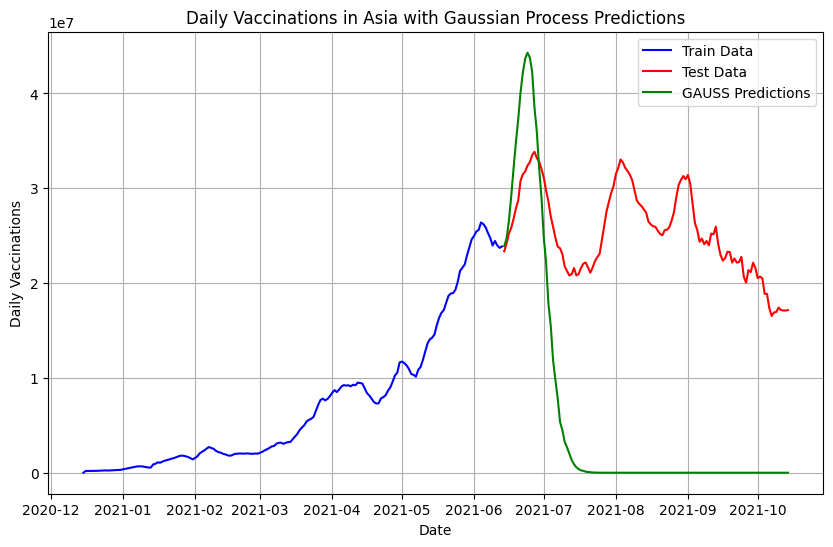

Training and testing Gaussian Process for Europe


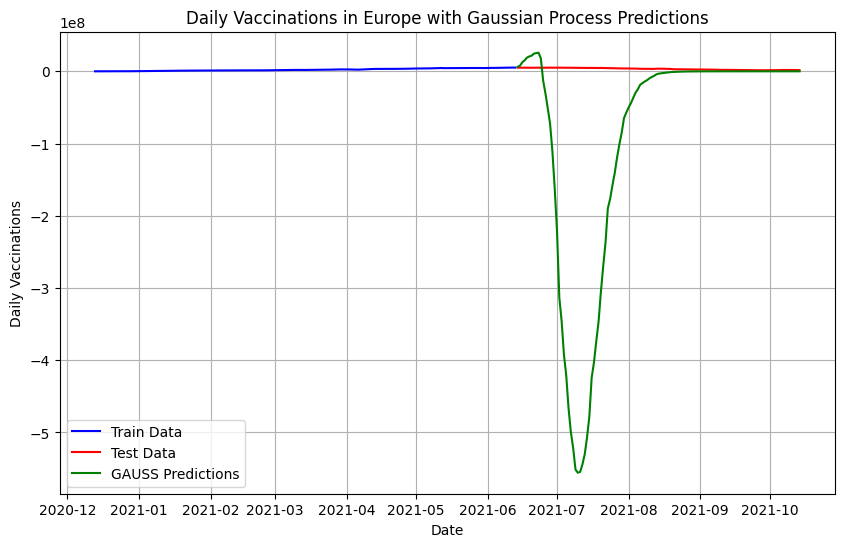

Training and testing Gaussian Process for European Union


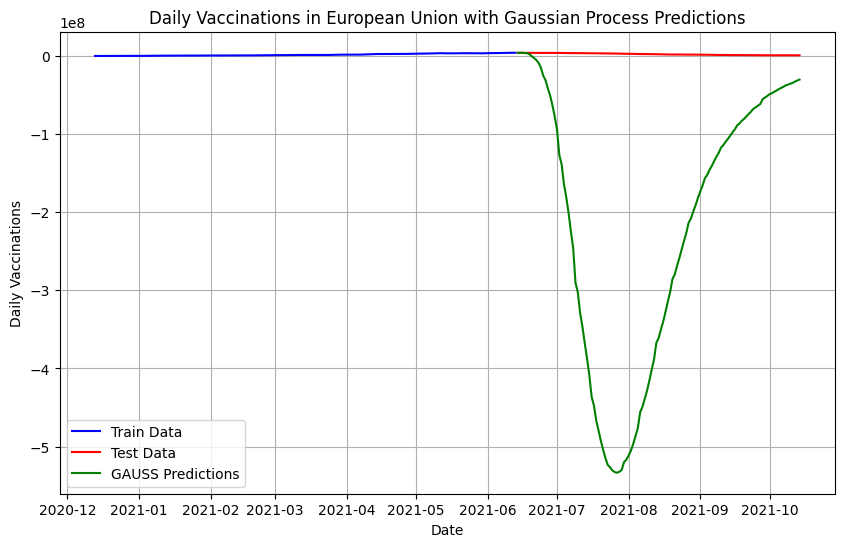

Training and testing Gaussian Process for North America


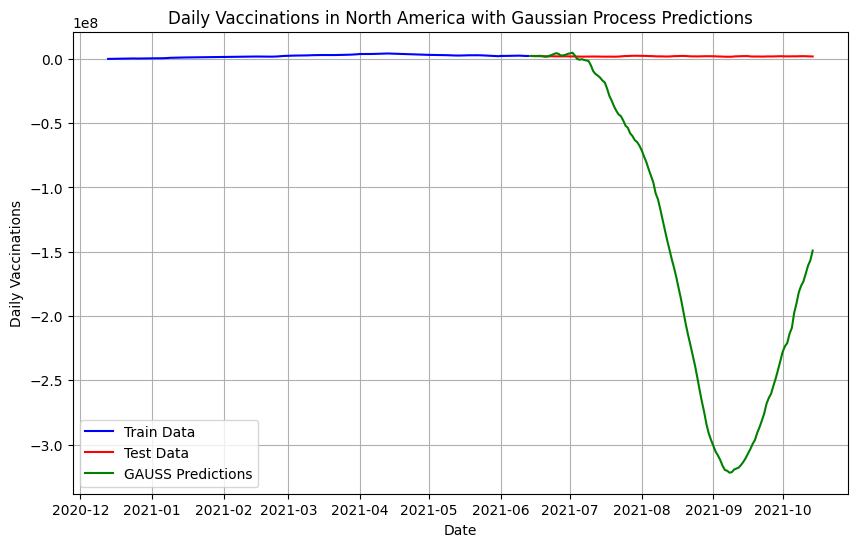

Training and testing Gaussian Process for Oceania


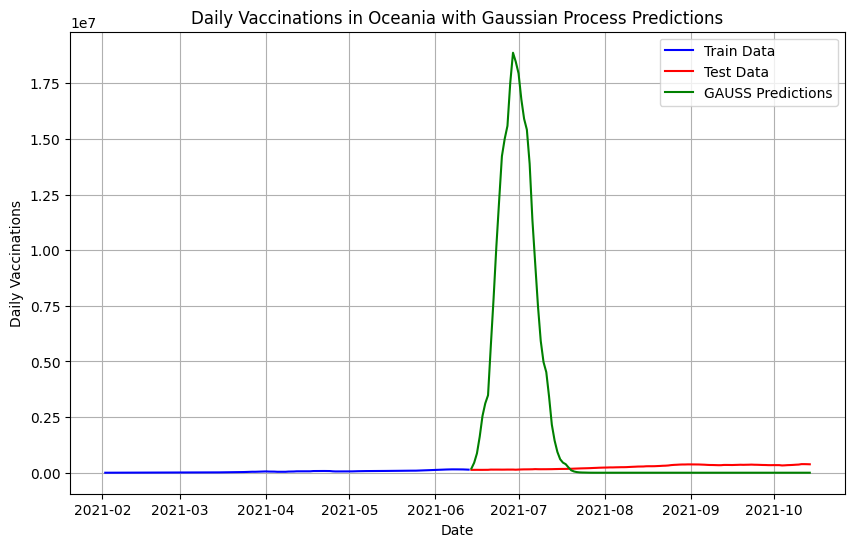

Training and testing Gaussian Process for South America


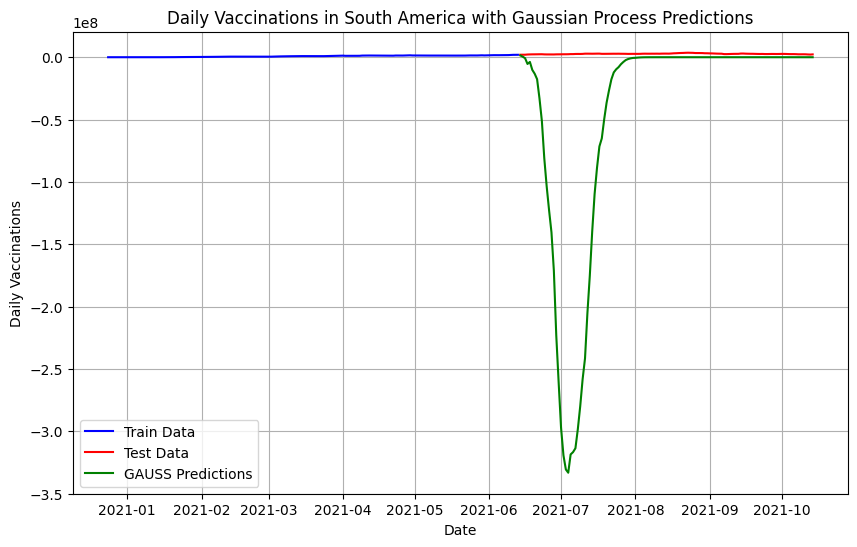

Training and testing Gaussian Process for World


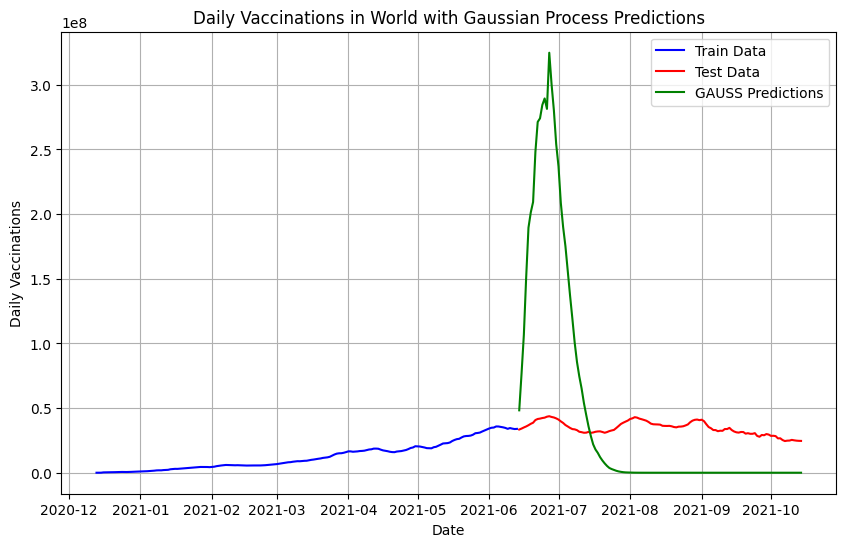

Gaussian Process RAE DataFrame:
                                  RAE
GAUSS_Africa_RAE            66.232855
GAUSS_Asia_RAE               5.600608
GAUSS_Europe_RAE            80.261303
GAUSS_European Union_RAE   210.862624
GAUSS_North America_RAE   1057.937591
GAUSS_Oceania_RAE           29.748307
GAUSS_South America_RAE    188.077369
GAUSS_World_RAE             13.914738

Gaussian Process MSLE DataFrame:
                               MSLE
GAUSS_Africa_MSLE               NaN
GAUSS_Asia_MSLE            0.658555
GAUSS_Europe_MSLE               NaN
GAUSS_European Union_MSLE       NaN
GAUSS_North America_MSLE        NaN
GAUSS_Oceania_MSLE         3.790082
GAUSS_South America_MSLE        NaN
GAUSS_World_MSLE           0.857106

Gaussian Process MASE DataFrame:
                                  MASE
GAUSS_Africa_MASE          2340.334276
GAUSS_Asia_MASE              89.319591
GAUSS_Europe_MASE          2142.709878
GAUSS_European Union_MASE  6821.641984
GAUSS_North America_MASE   3087.075821


In [123]:
# prompt: train and  test for Gaussian Process (GAUSS)   for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
gauss_continent_rae = {}
gauss_continent_msle = {}
gauss_continent_mase = {}
gauss_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Gaussian Process for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Gaussian Process
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create Gaussian Process model
    model = GaussianProcessRegressor()

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    gauss_continent_rae[f'GAUSS_{continent}_RAE'] = rae
    gauss_continent_msle[f'GAUSS_{continent}_MSLE'] = msle
    gauss_continent_mase[f'GAUSS_{continent}_MASE'] = mase
    gauss_continent_predictions[f'GAUSS_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='GAUSS Predictions')

    plt.title(f'Daily Vaccinations in {continent} with Gaussian Process Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()


# Create DataFrames for RAE, MSLE, and MASE
gauss_rae_df = pd.DataFrame.from_dict(gauss_continent_rae, orient='index', columns=['RAE'])
gauss_msle_df = pd.DataFrame.from_dict(gauss_continent_msle, orient='index', columns=['MSLE'])
gauss_mase_df = pd.DataFrame.from_dict(gauss_continent_mase, orient='index', columns=['MASE'])


print("Gaussian Process RAE DataFrame:")
print(gauss_rae_df)

print("\nGaussian Process MSLE DataFrame:")
print(gauss_msle_df)

print("\nGaussian Process MASE DataFrame:")
print(gauss_mase_df)
